## Question: What Type of Skillset is Optimal for Rock Climbing?

#### First lets initialize the data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import math
import glob
import os
import imageio

#### Here are Our Classes

In [15]:
class Climber:
    """
    Class representing a climber
    Attributes:
        reach - radius of movement for the climber
        sloper - climber strength on slopers
        crimp - climber strength on crimps
        jug - climber strength on jugs
        heights - list of heights reached by the climber on a series of walls
        icon - marker for visuals the climber is in
        position - coordinates for the climber on a wall
    
    methods:
        make_move(): evaluate if it is feasible to 'stick' a move to one of the holds on the wall or if the climber falls and 
                     does not reach any with their given abilities
        average_h(): returns the average height the climber achieved on the walls it was run on
        set_position(): Sets position, can be used to reset after climbing a wall
    """
    
    def __init__(self, reach, sloper, crimp, jug, position = np.array([5,0]), icon="*"):
        self.reach = reach
        ##Strength (Percent Chance of Sticking a Move To) on Different Types of Holds/Rock
        self.sloper = sloper
        self.crimp = crimp
        self.jug = jug
        ##Location on the wall
        self.position = position
        ##Icon for visualization
        self.icon = icon
        self.heights = []
        
    def make_move(self, holds):
        '''Accepts a list of holds on a wall, will attempt to move to a nearby hold higher up on the wall'''
        reachable = []
        for hold in holds:
            if self.reach > np.linalg.norm(self.position-hold.coords) and self.position[1]-hold.coords[1] < 0 and np.linalg.norm(self.position - hold.coords) != 0:
                reachable.append(hold)
        reached = []
        reached_dists = []
        for hold in reachable:
            if hold.type == 'jug':
                if random.random() <= self.jug:
                    reached.append(hold.coords)
            elif hold.type == 'sloper':
                if random.random() <= self.sloper:
                    reached.append(hold.coords)
            elif hold.type == 'crimp':
                if random.random() <= self.crimp:
                    reached.append(hold.coords)
        if not reached:
            return 'fall'
        
        for i in reached:
            x = math.dist(self.position, i)
            reached_dists.append(x)
        self.position = reached[np.argmin(reached_dists)]
        
        return 'stuck'
    
    def set_position(self, position = np.array([5, 0])):
        '''Sets position, can be used to reset after climbing a wall'''
        self.position = np.array(position)
        
        
    def average_h(self):
        '''returns the average height the climber achieved on the walls it was run on'''
        return float(sum(self.heights))/len(self.heights)

In [16]:
class Hold:
    """
    Class representing a single hold
    Attributes:
    coords - coordinates of the hold 
    type - sloper, crimp, or jug
    """
    def __init__(self, coords, type_):
        self.coords = np.array(coords)
        self.type = type_

In [17]:
class Cell:
    """
    Class representing one 10 by 10 cell on a wall
    Attributes:
        slopers - number of sloper holds
        crimps - number of crimp holds
        jugs - number of jug holds
        height - height of the cell along the wall should be multiple of 10
        holds - array of hold objects in the cell
        hold_types - list of types of holds
    
    methods:
        show(): plots cell
    """
    def __init__(self, slopers, crimps, jugs, height = 0):
        ##Number of Each Type of Hold/Rock
        self.slopers = slopers
        self.crimps = crimps
        self.jugs = jugs
        self.num_cells = 1
        ##Setting Coordinates of the Holds
        self.total_holds = self.slopers + self.crimps + self.jugs
        self.x = np.random.randint(1, 11, size = self.total_holds)
        self.y = np.random.randint(1, 11, size = self.total_holds)
        self.holds = []
        self.hold_types = []
        for i in range(slopers):
            new_hold = Hold([self.x[i], self.y[i]+height], "sloper")
            self.holds.append(new_hold)
            self.hold_types.append("sloper")
        for j in range(crimps):
            new_hold = Hold([self.x[j+i], self.y[j+i]+height], "crimp")
            self.holds.append(new_hold)
            self.hold_types.append("crimp")
        for k in range(jugs):
            new_hold = Hold([self.x[k+j+i], self.y[k+j+i]+height], "jug")
            self.holds.append(new_hold)       
            self.hold_types.append("jug")
        
    def show(self):
        '''Plots cell with all holds'''
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.holds, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10])
        plt.show()
    


In [18]:
class Wall:
    """
    Class representing a whole wall, made up of cells
    Attributes:
        slopers - number of sloper holds
        crimps - number of crimp holds
        jugs - number of jug holds
        height - height of the cell along the wall. should be multiple of 10
        holds - array of hold objects in the cell
        x - array of x coordinates of the holds
        y - array of y coordinates of the holds
        hold_cords - list of coordinates of the holds
        total_holds - number of total holds
        hold_types - list of types of holds
        
    methods:
        show(): plots wall
        run_wall(): Takes in a climber object and simulates the climber attempting to climb the wall. Returns a list of all 
                    points the holder occupied during their path
        plot_path():Stores a GIF of a climber moving up the wall, drawing a line to each hold for the moves made
    """
    def __init__(self, smallwall, cell):
        ##Number of Each Type of Hold/Rock
        self.slopers = smallwall.slopers + cell.slopers
        self.crimps = smallwall.crimps + cell.crimps
        self.jugs = smallwall.jugs + cell.jugs
        self.num_cells = smallwall.num_cells + cell.num_cells
        self.hold_types = smallwall.hold_types + cell.hold_types
        ##Setting Coordinates of the Holds
        self.total_holds = self.slopers + self.crimps + self.jugs
        self.x = np.concatenate((smallwall.x, cell.x))
        self.y = np.concatenate((smallwall.y, cell.y + np.repeat(10*(self.num_cells-1), len(cell.y))))
        self.holds = np.concatenate((smallwall.holds, cell.holds))
        self.hold_cords = []
        for i in range(self.total_holds):
            self.hold_cords.append([self.x[i], self.y[i]])
        
    def show(self, show_scale = 1, title = 'Rock Wall'):
        '''Plots Wall with all holds shown'''
        fig = plt.figure(figsize = (10*show_scale, len(self.x)*show_scale))
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10*self.num_cells])
        plt.title(title)
        plt.show()
        
    def run_wall(self, climber):
        '''Takes in a climber object and simulates the climber attempting to climb the wall. 
        Returns a list of all points the holder occupied during their path'''
        path = []
        status = "stuck"
        while status == "stuck":
            path.append(climber.position)
            status = climber.make_move(self.holds)
        climber.set_position()
        return path
    
    def plot_path(self, path, show_scale = 1, title = 'Rock Wall'):
        '''Stores a GIF of a climber moving up the wall, drawing a line to each hold for the moves made'''
        # Delete files that currently exist in generated_frames folder
        files = glob.glob('./generated_frames/*')
        for f in files:
            os.remove(f)
        
        for i in range(len(path)):
            fig = plt.figure(figsize = (10*show_scale, len(self.x)*show_scale))
            ax = plt.subplot(111)
            line, = ax.plot([], [], 'g', lw = 2)

            sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
            ax.set_xlim([0, 10])
            ax.set_ylim([0, 10*self.num_cells])
            ax.set_title(title)
        
            x, y = path[i]
            
            line.set_xdata([point[0] for point in path[:i]])
            line.set_ydata([point[1] for point in path[:i]])

            fig.canvas.draw()
            fig.canvas.flush_events()

            plt.savefig(f'./generated_frames/img_{i}.png', transparent = False, facecolor = 'white')

        print("Saved all frames")
        
        # Load frames with imageio
        frames = []
        for i in range(len(path)):
            image = imageio.imread(f"./generated_frames/img_{i}.png")
            frames.append(image)
        
        print("Generating gif...")
        imageio.mimsave(
            "./generated_frames/combined.gif",
            frames, # array of input frames
            fps = 5 # optional: frames per second
        )
        print("Gif generated!")

In [19]:
##Notes
##We decided two holds being placed in the same location is appropriate given that many climbing gyms will drill one hold on 
##top of another to make the move easier/more attainable for different climbing types

Below are all of the functions we use

In [20]:
def create_wall(cells, slopers, crimps, jugs):
    '''Creates a wall with given specifications'''
    cell1 = Cell(slopers, crimps, jugs)
    cell2 = Cell(slopers, crimps, jugs, 10)
    smallwall = Wall(cell1,cell2)
    for i in range(cells-2):
        cell1 = Cell(slopers, crimps, jugs, (i+2)*10)
        smallwall = Wall(smallwall, cell1)
    return smallwall

In [21]:
def create_climbers(n, reach, sloper, crimp, jug):
    '''Each input other than n is a list of 2 numbers, a min and a max for that attribute
        Creates a list of n climbers with attributes '''
    climber_list = []
    for i in range(n):
        reach1 = random.uniform(reach[0], reach[1])
        sloper1 = random.uniform(sloper[0], sloper[1])
        crimp1 = random.uniform(crimp[0], crimp[1])
        jug1 = random.uniform(jug[0], jug[1])
        climber1 = Climber(reach1, sloper1, crimp1, jug1)
        climber_list.append(climber1)
    return climber_list

In [22]:
def simulate(climbers, walls):
    '''Takes in a list of climbers and walls, runs all climbers on all walls, keeping track of how high they made it'''
    for wall in walls:
        for climber in climbers:
            path = wall.run_wall(climber)
            height = path[-1][1]
            climber.heights.append(height)
            

#### Example showing our code in action (two walls, two climbers, plot path)

In [25]:
# Below we created an elaborate wall

wall1 = create_wall(2, 11, 5, 5) # more slopers
wall2 = create_wall(2, 5, 11, 5) #more crimps

# Below we created two climbers with varying styles

sloper_climber = Climber(5, 0.8, 0.5, 0.6) #stronger on slopers and average on the rest
crimp_climber = Climber(5, 0.4, 0.9, 0.6) #stronger on crimps and average on the rest

Saved all frames
Generating gif...
Gif generated!


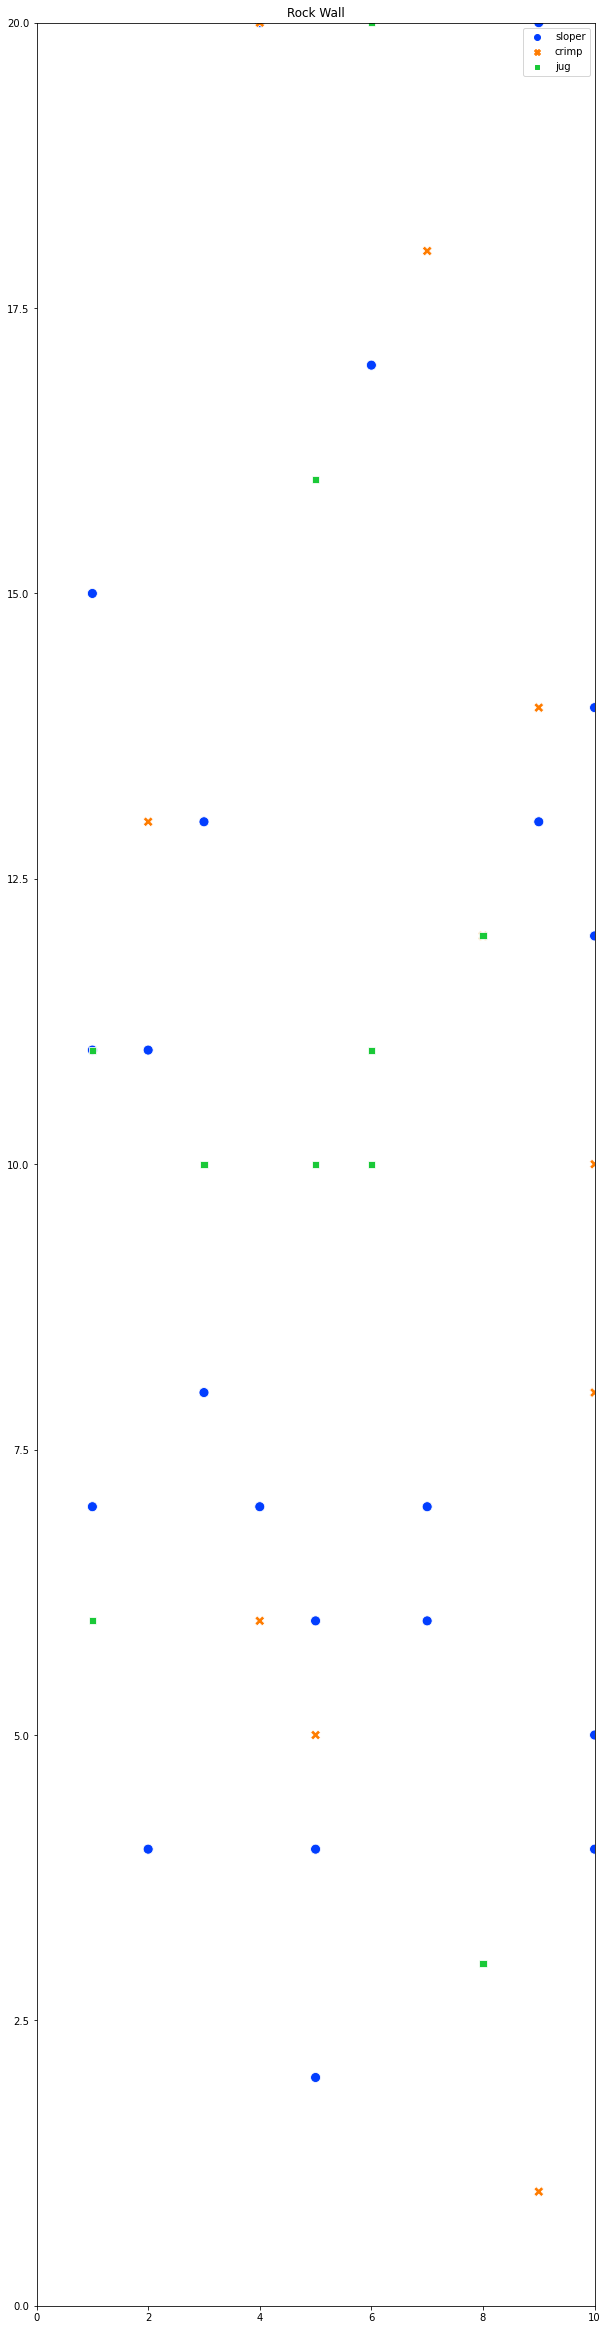

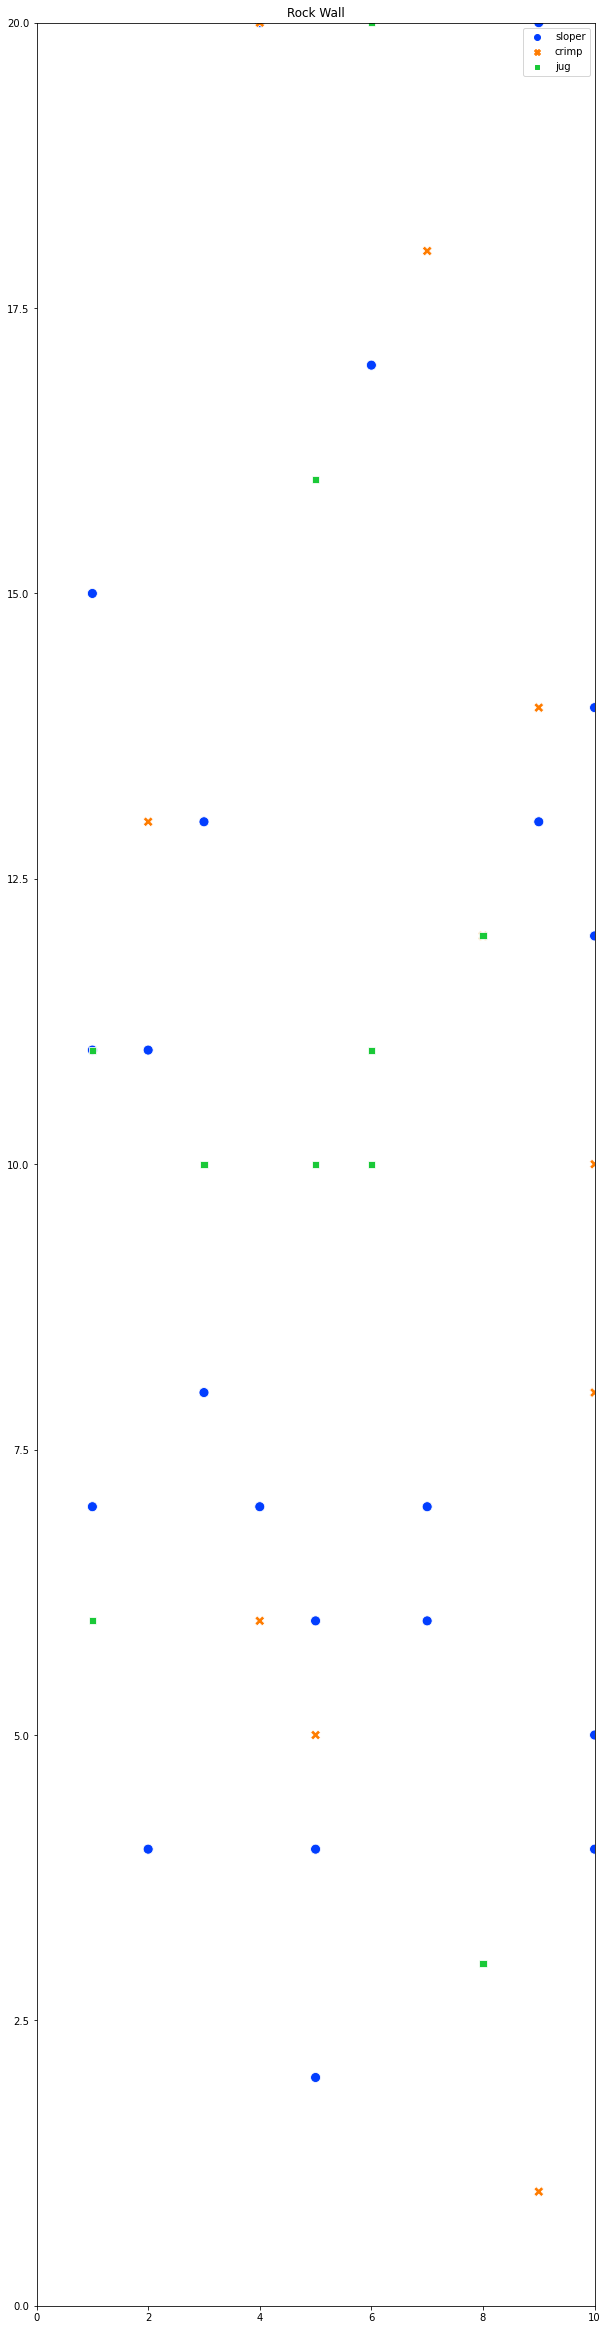

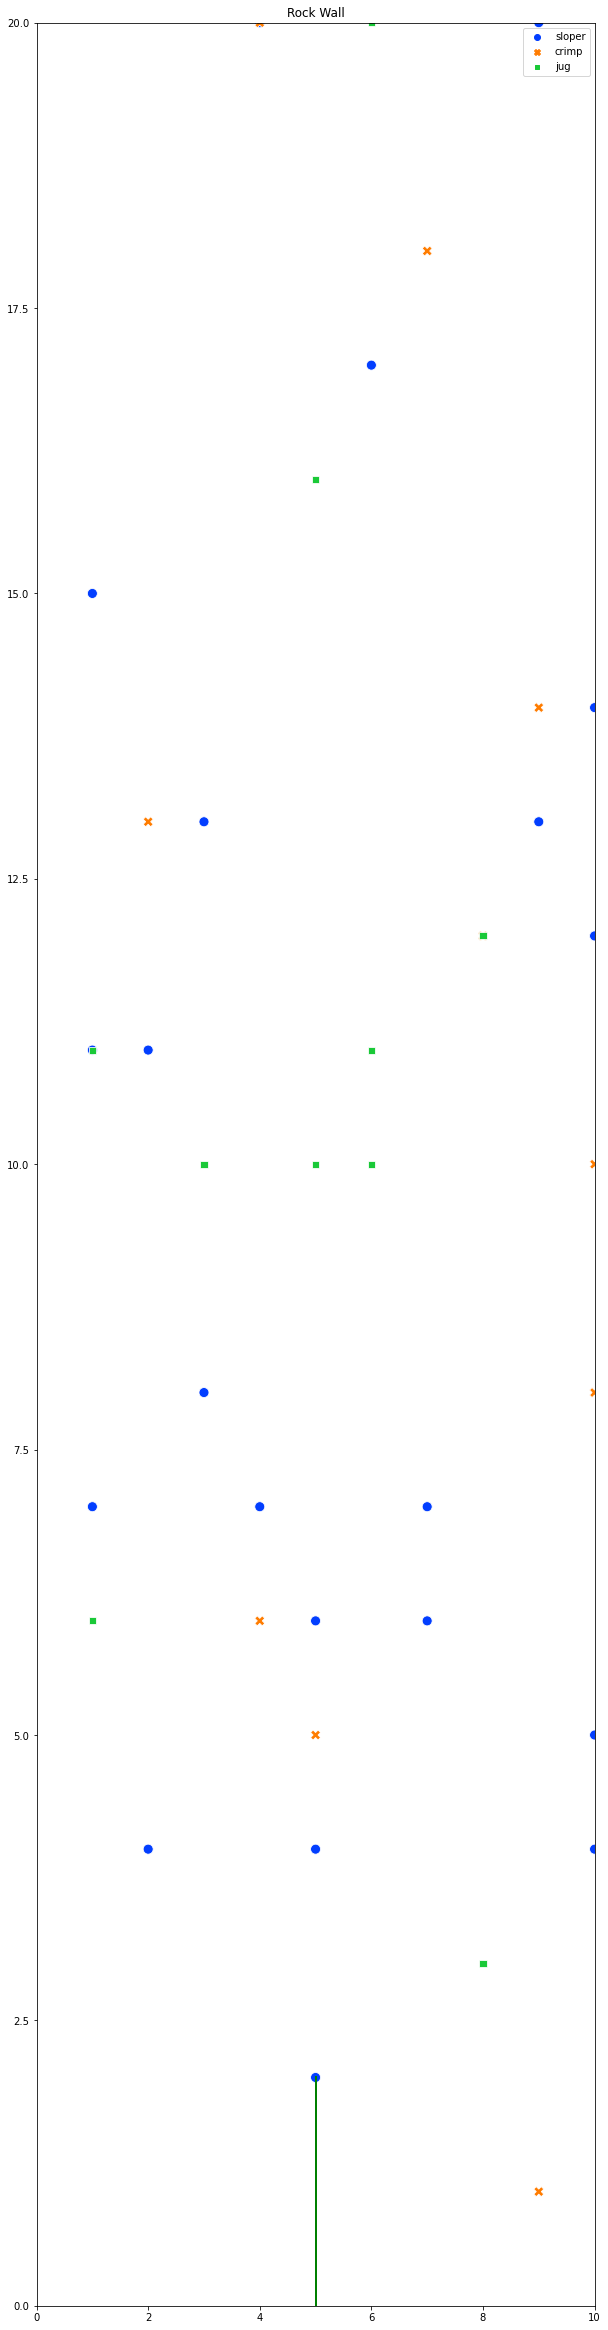

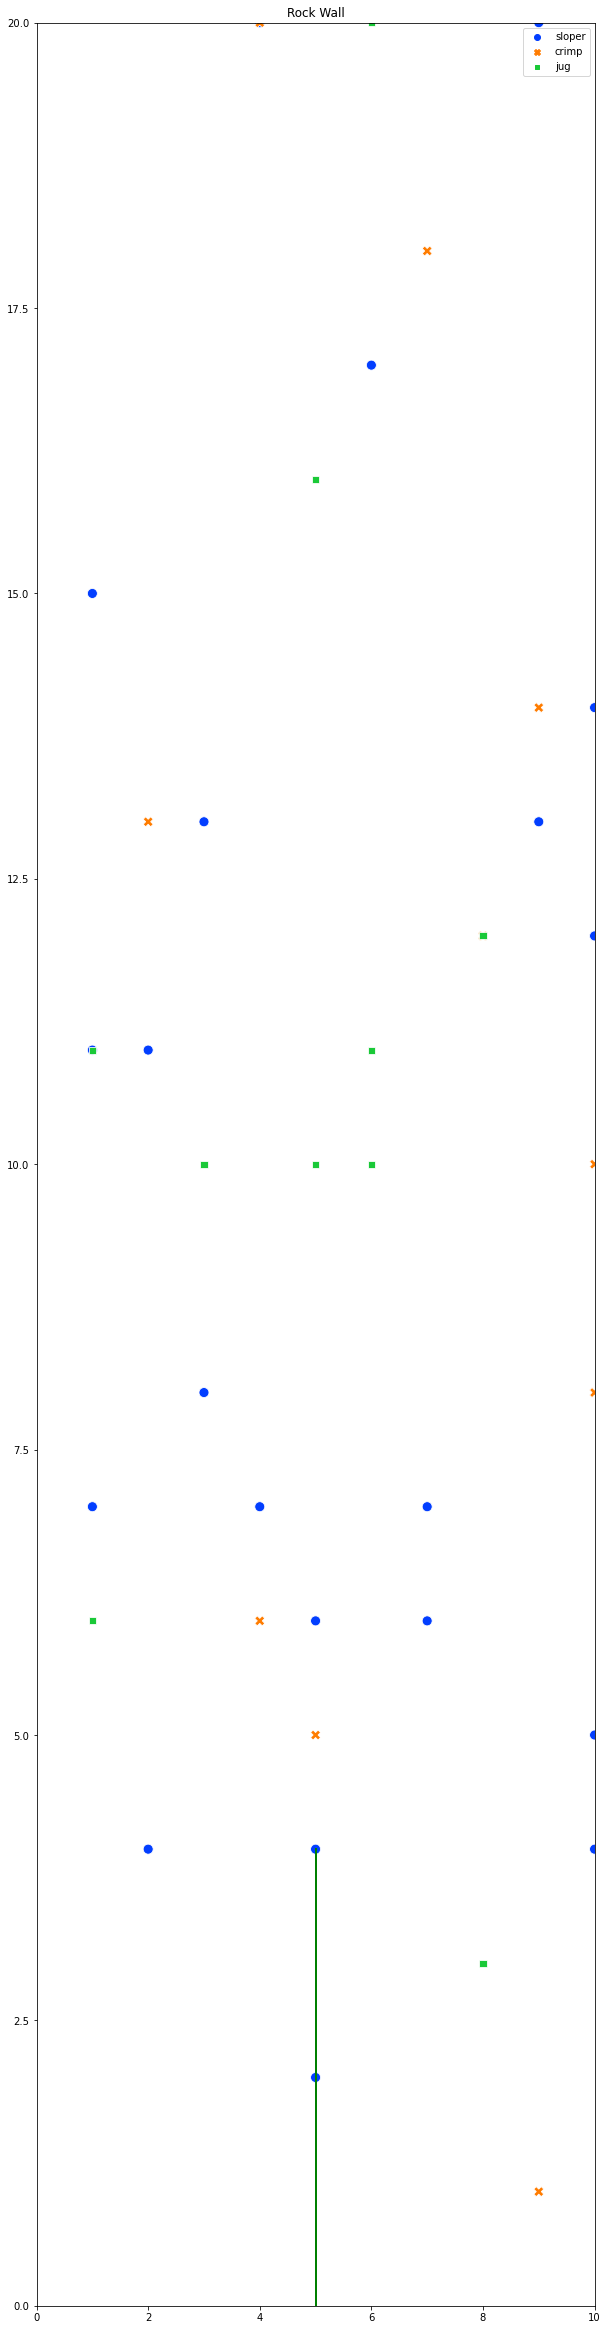

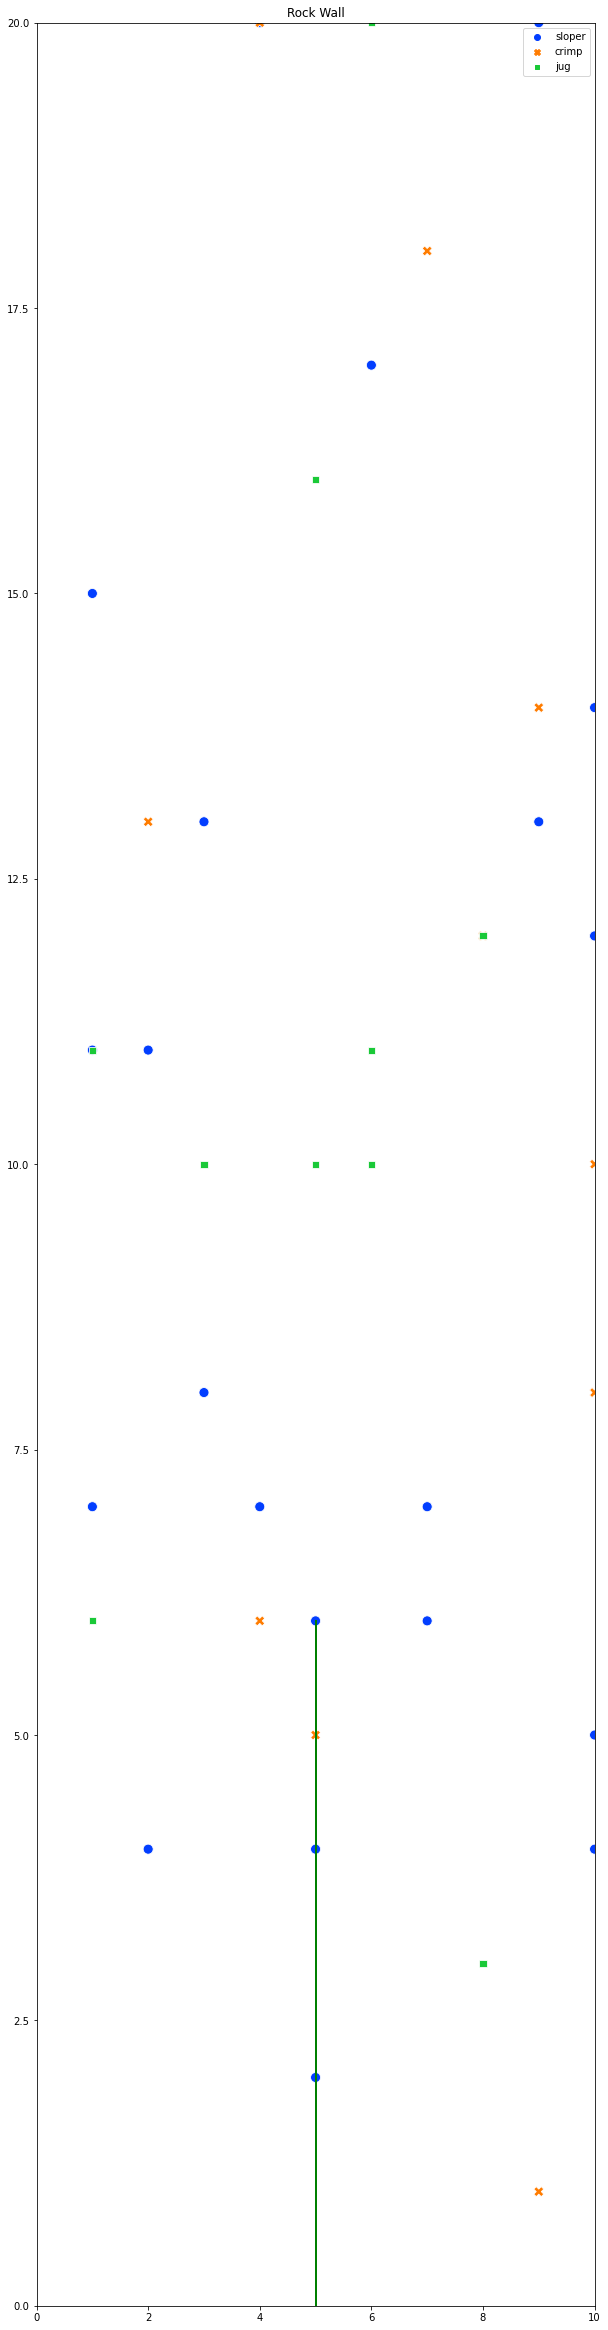

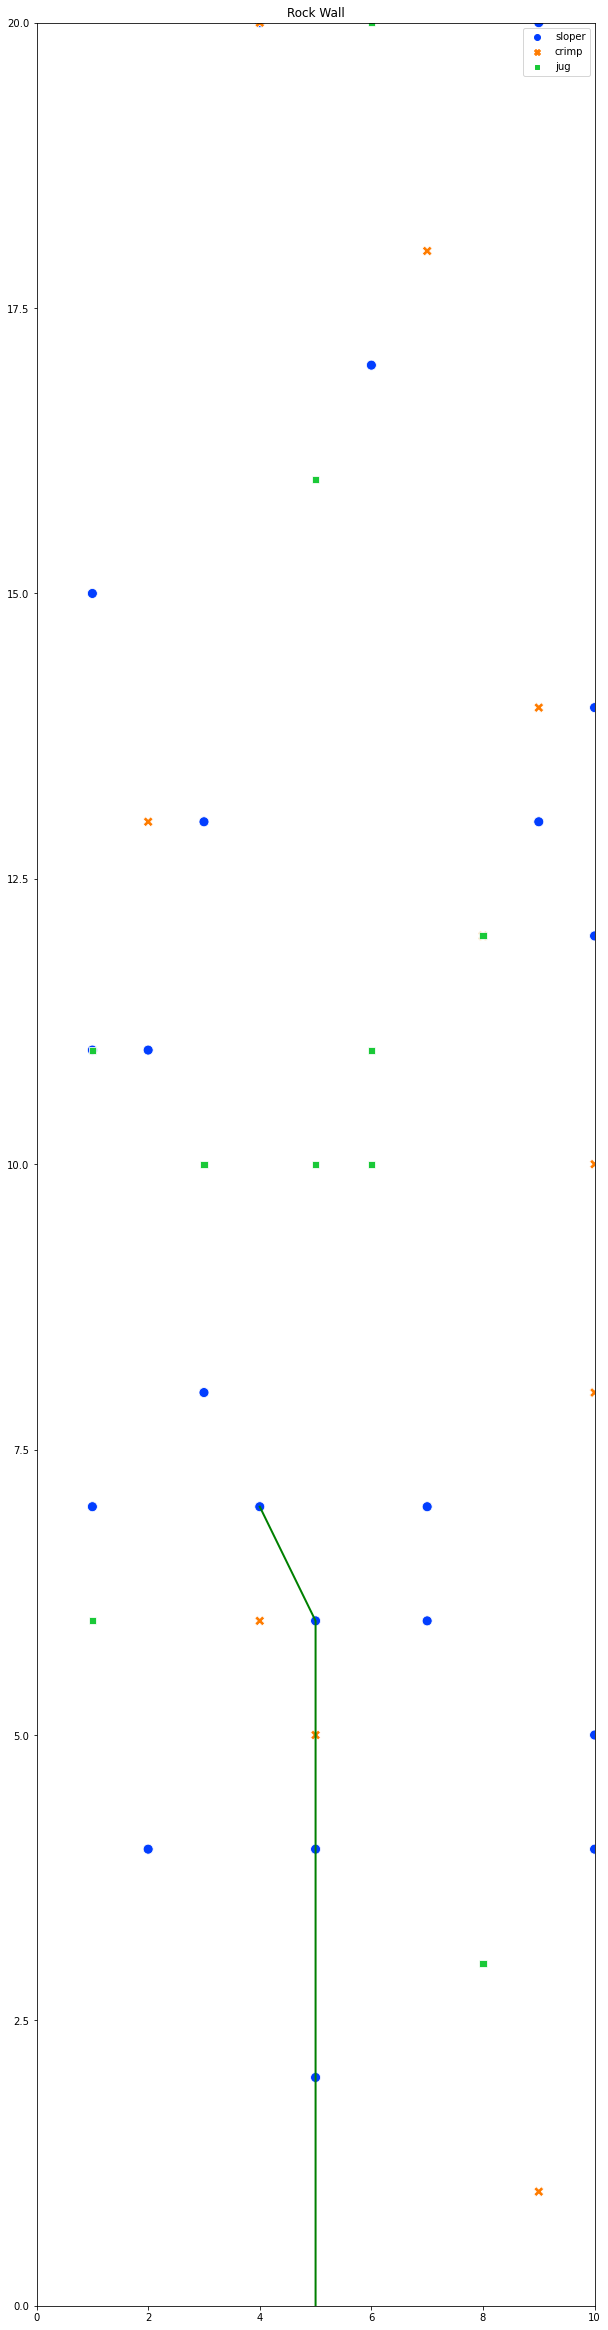

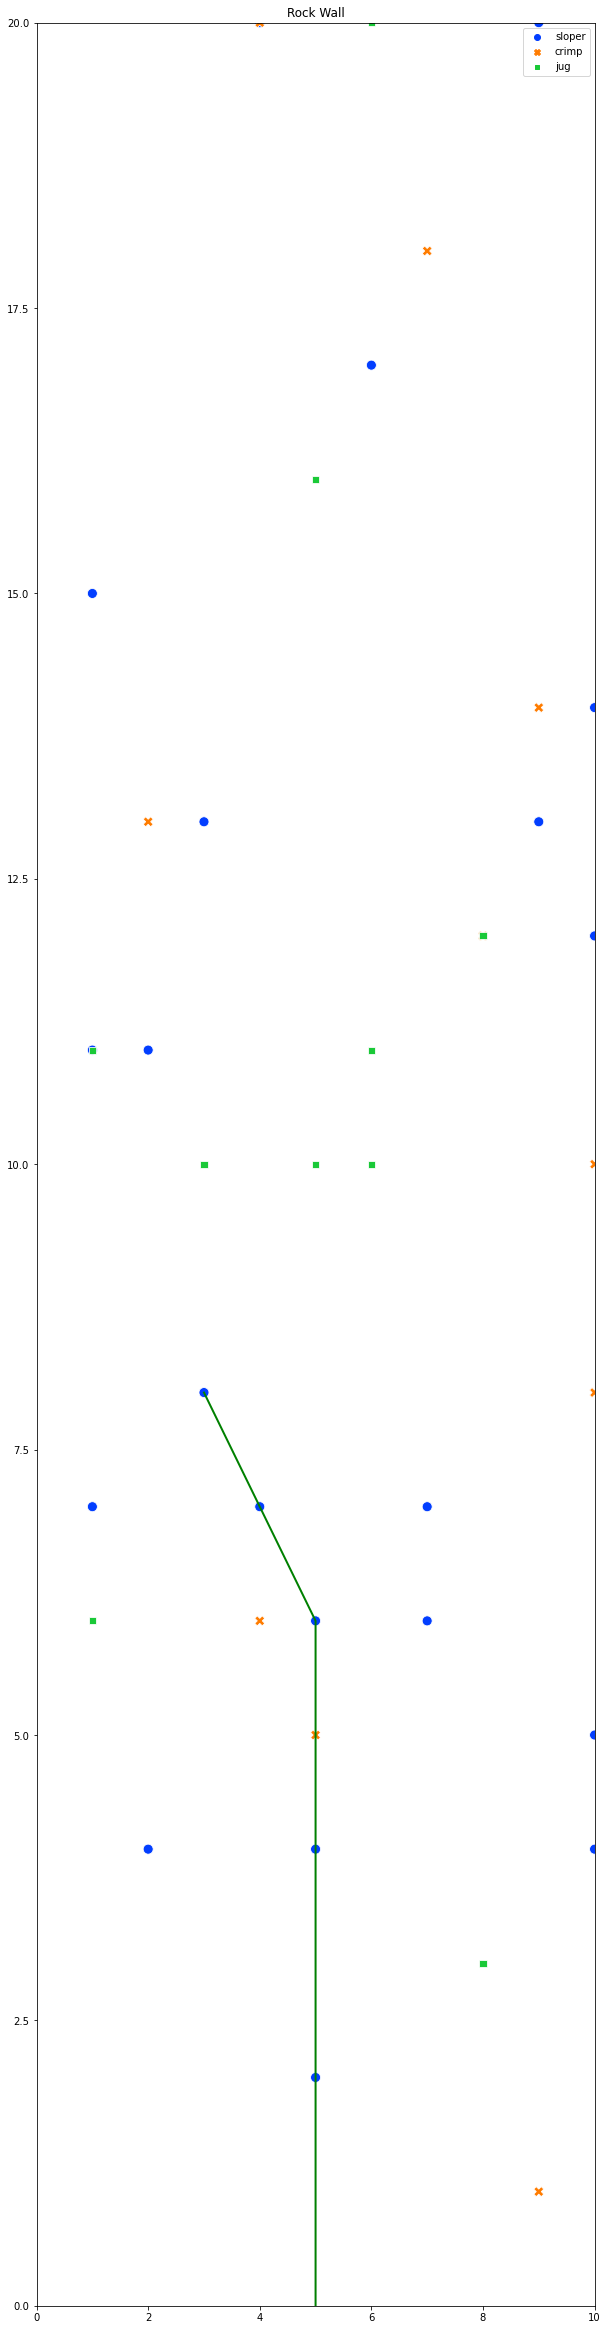

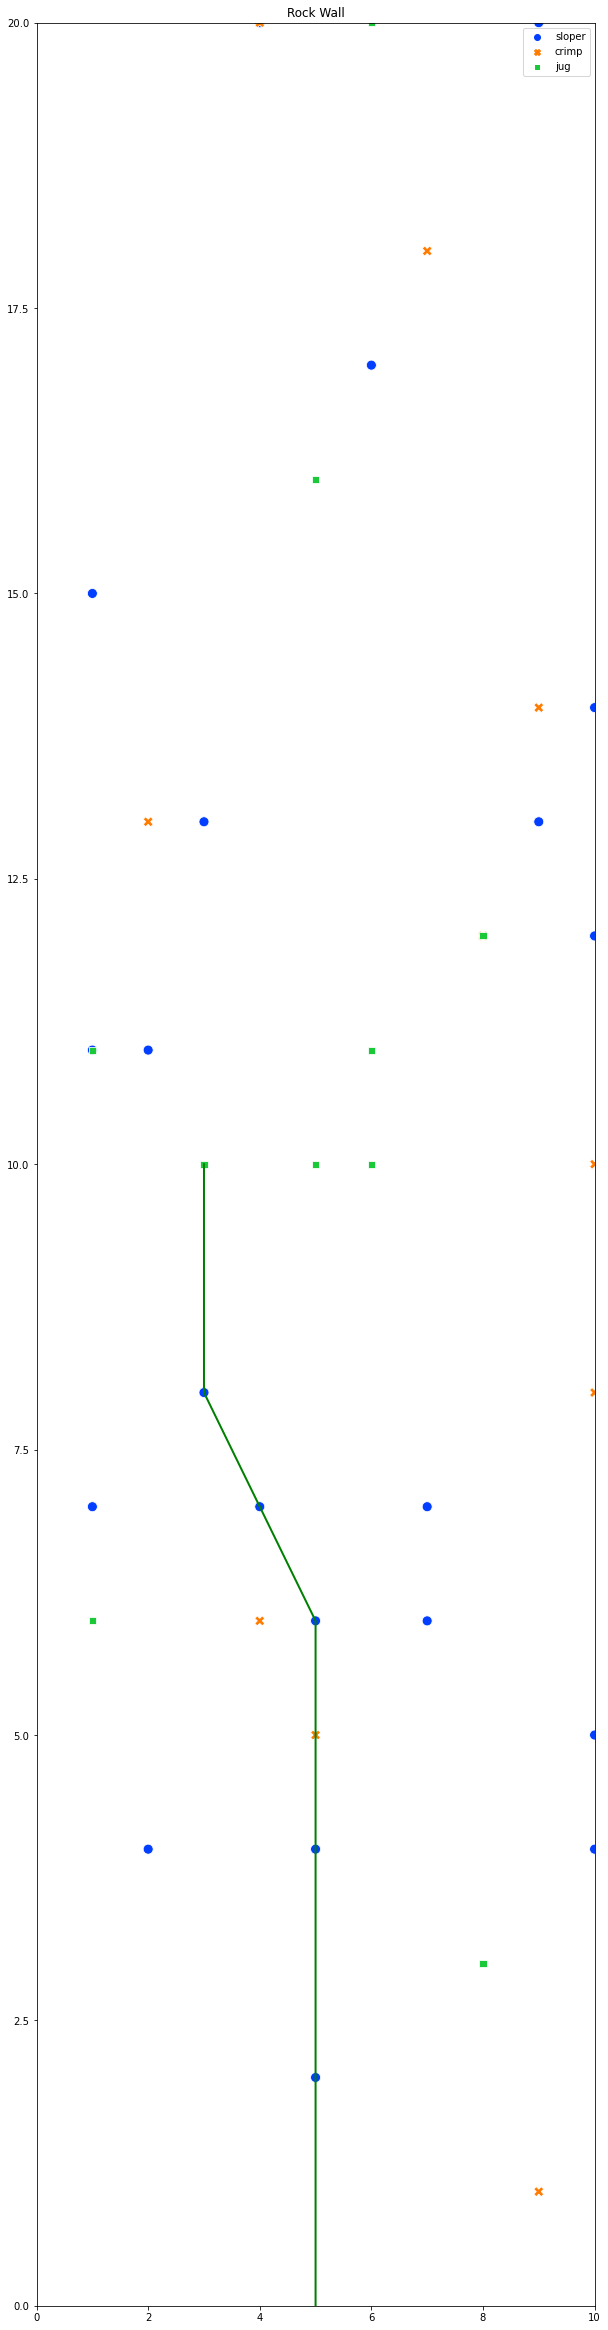

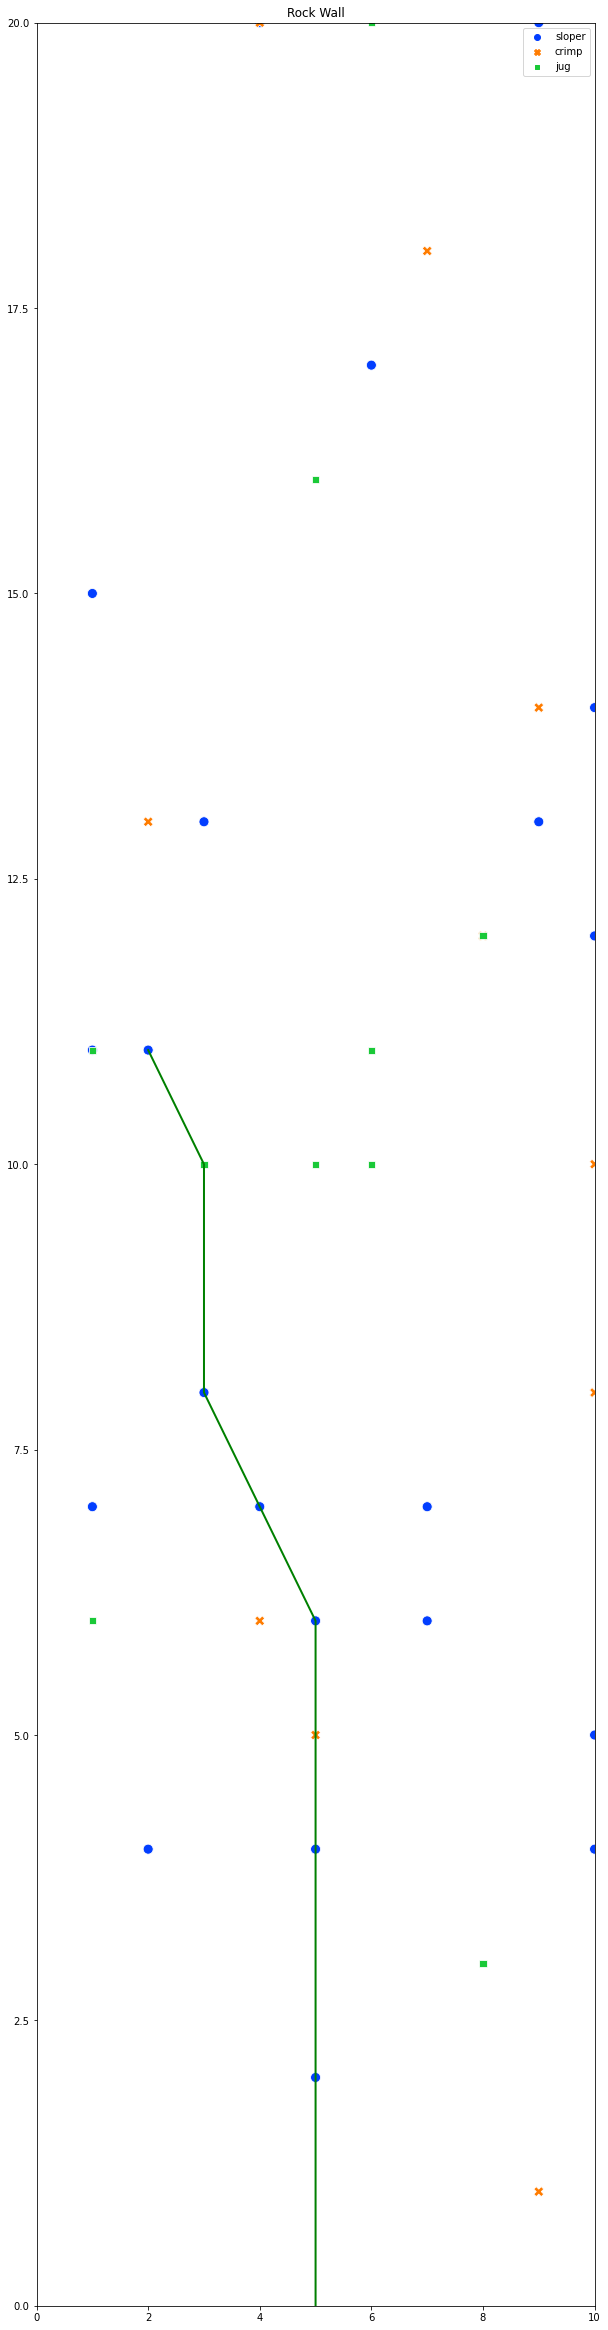

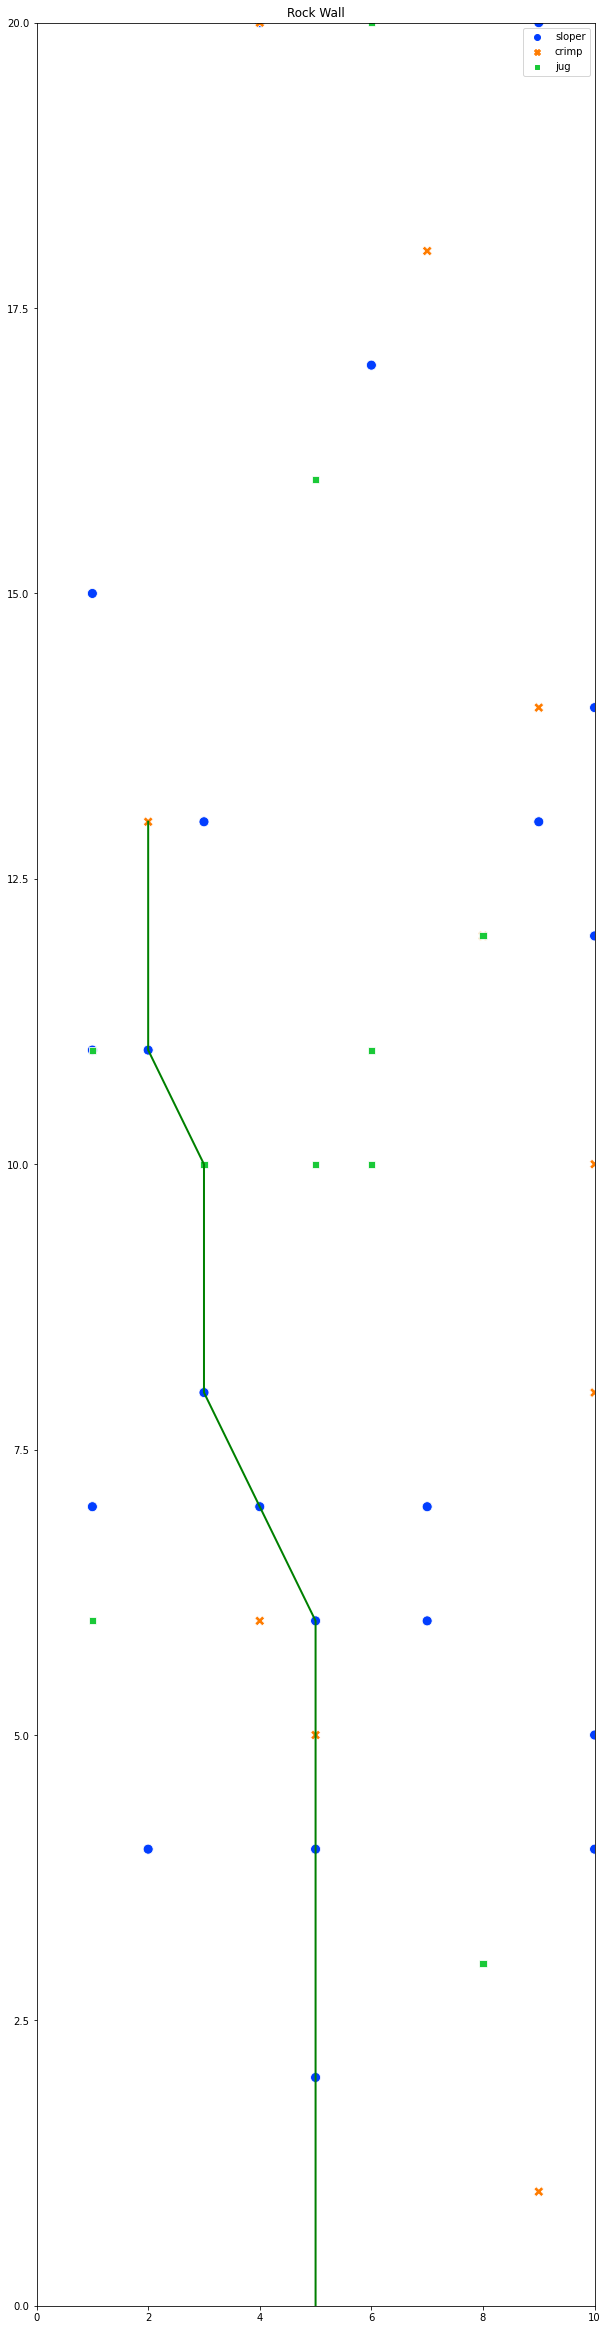

In [26]:
##Below and in subsequent cells we have the climbers climb the walls and then visualize this

wall1.plot_path(wall1.run_wall(sloper_climber))

Saved all frames
Generating gif...
Gif generated!


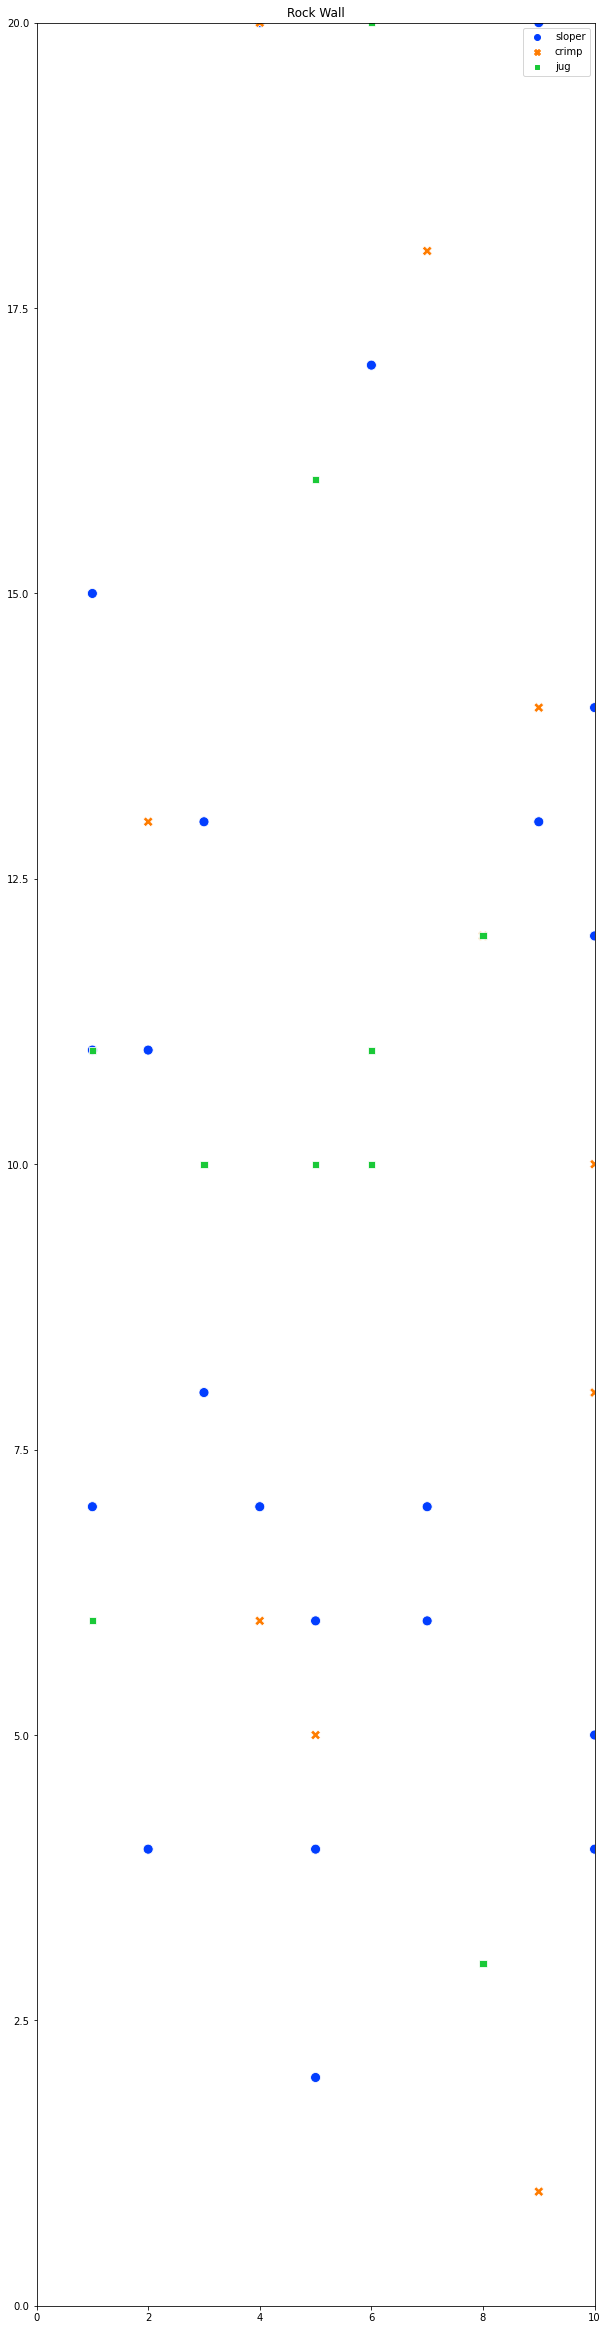

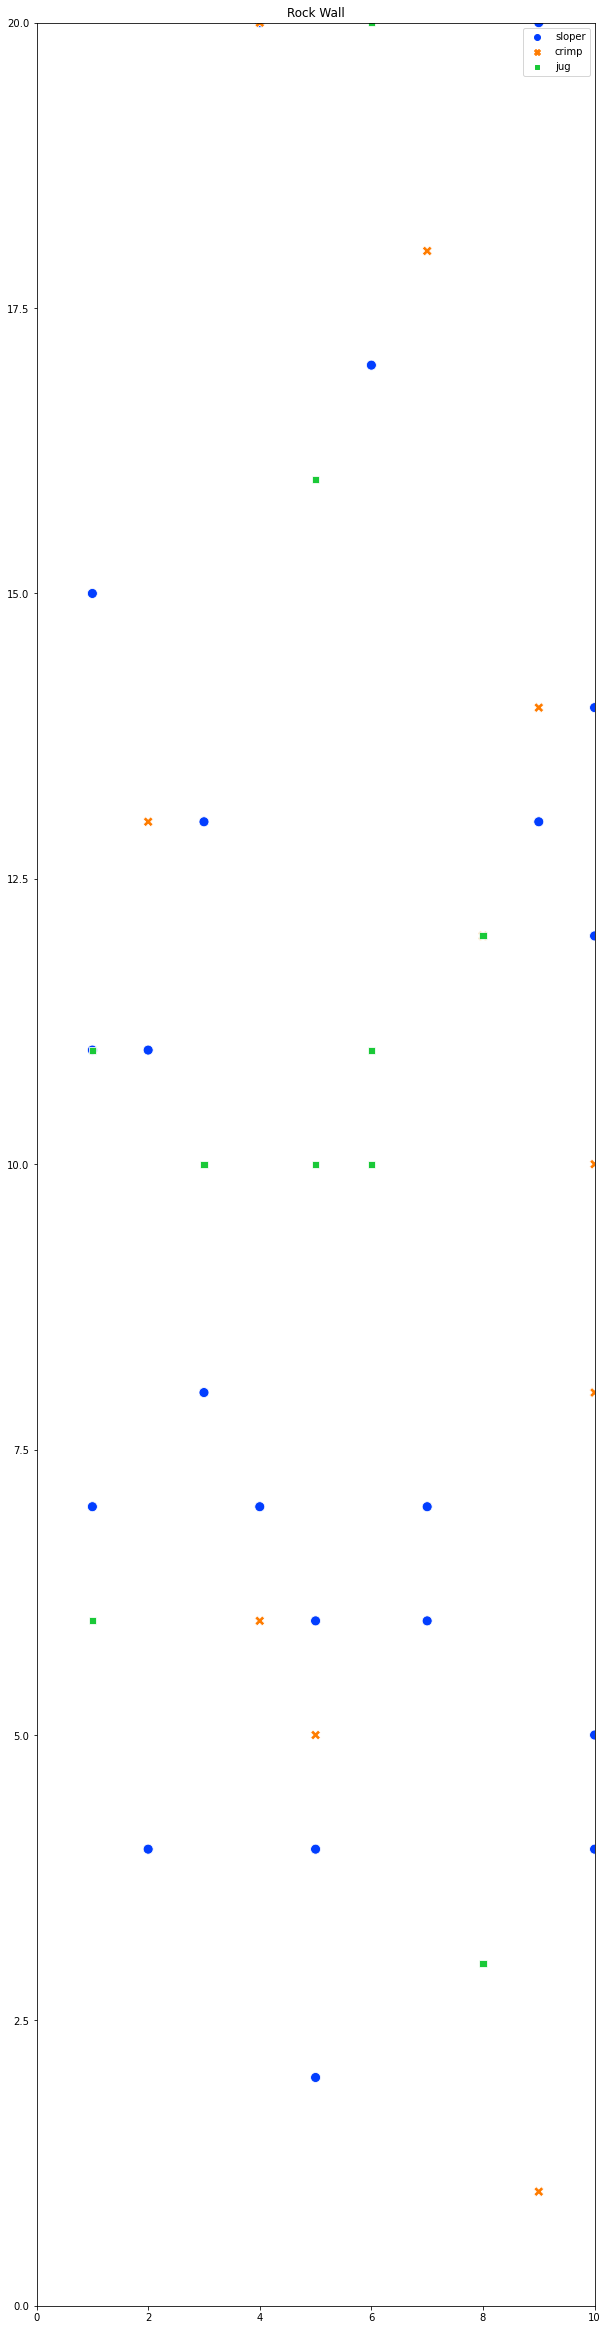

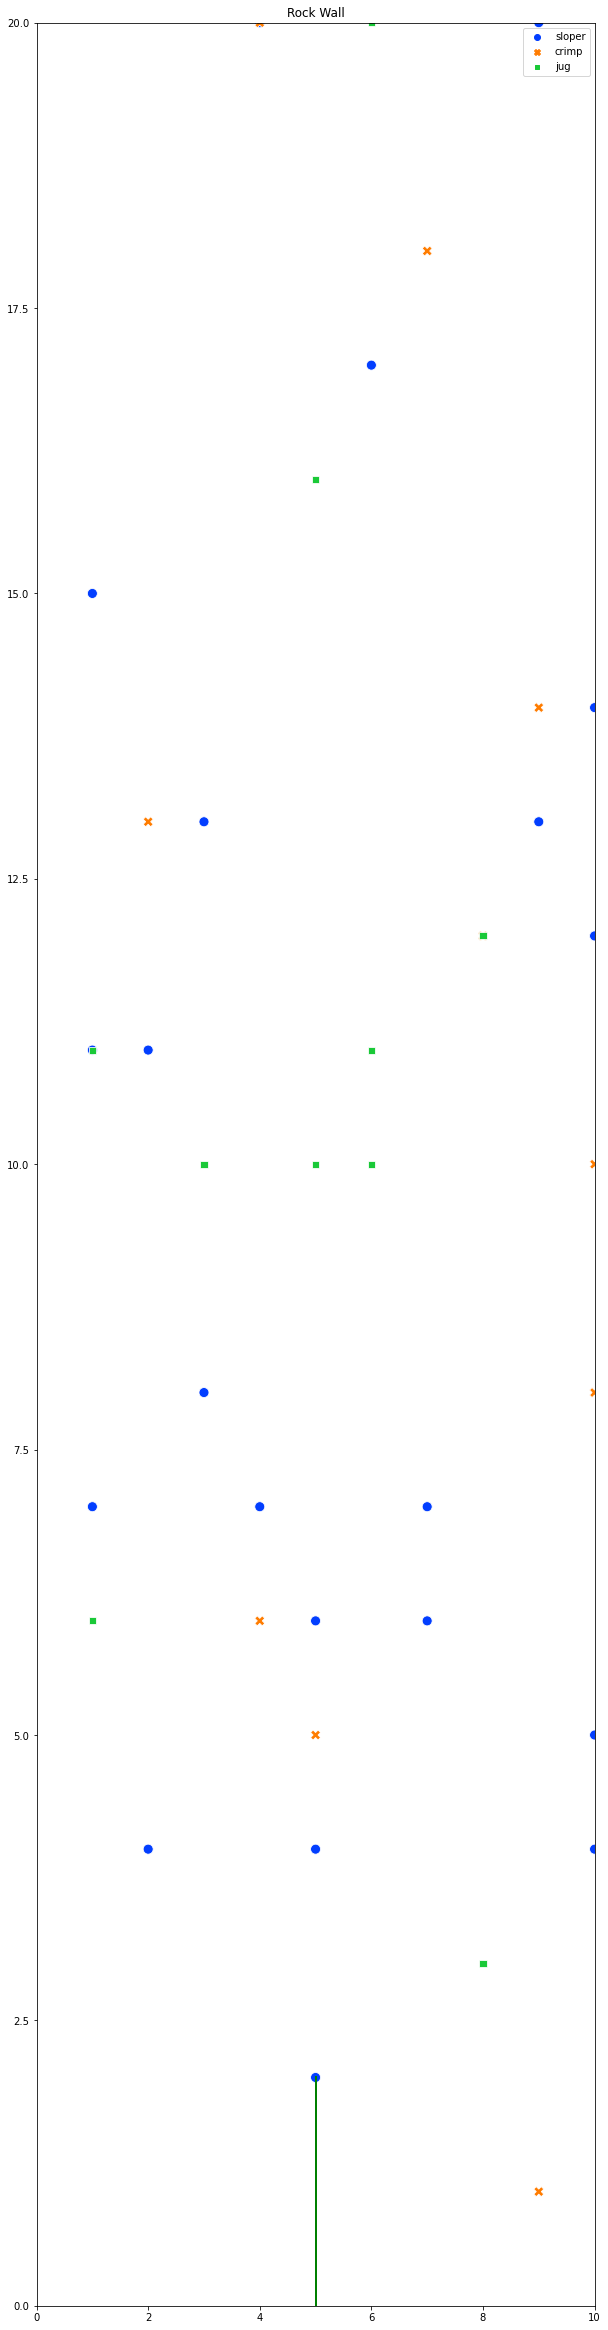

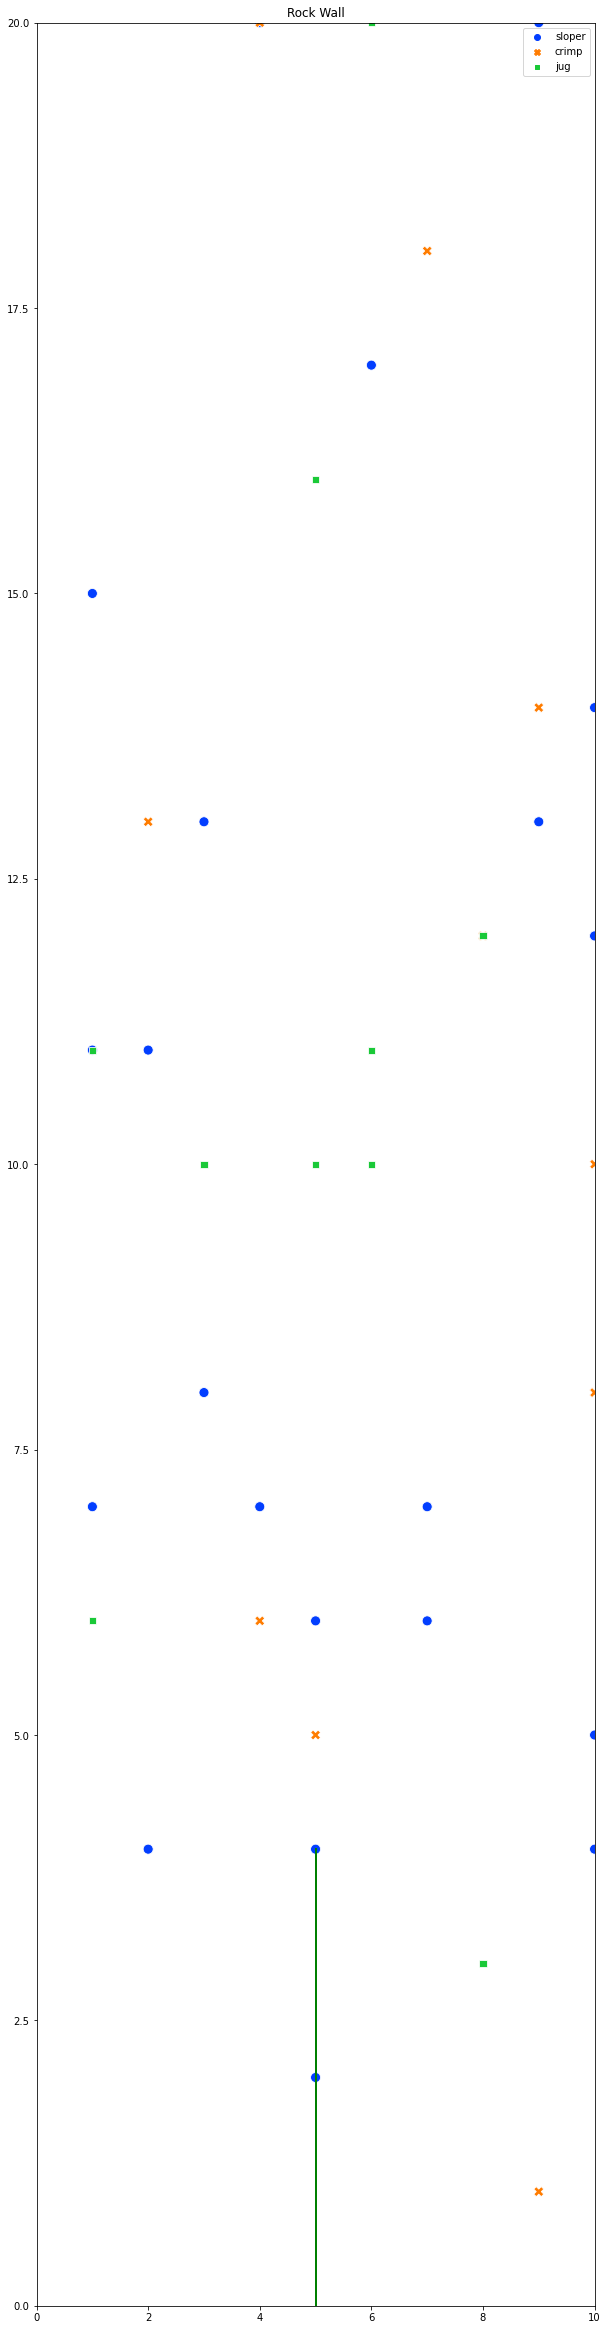

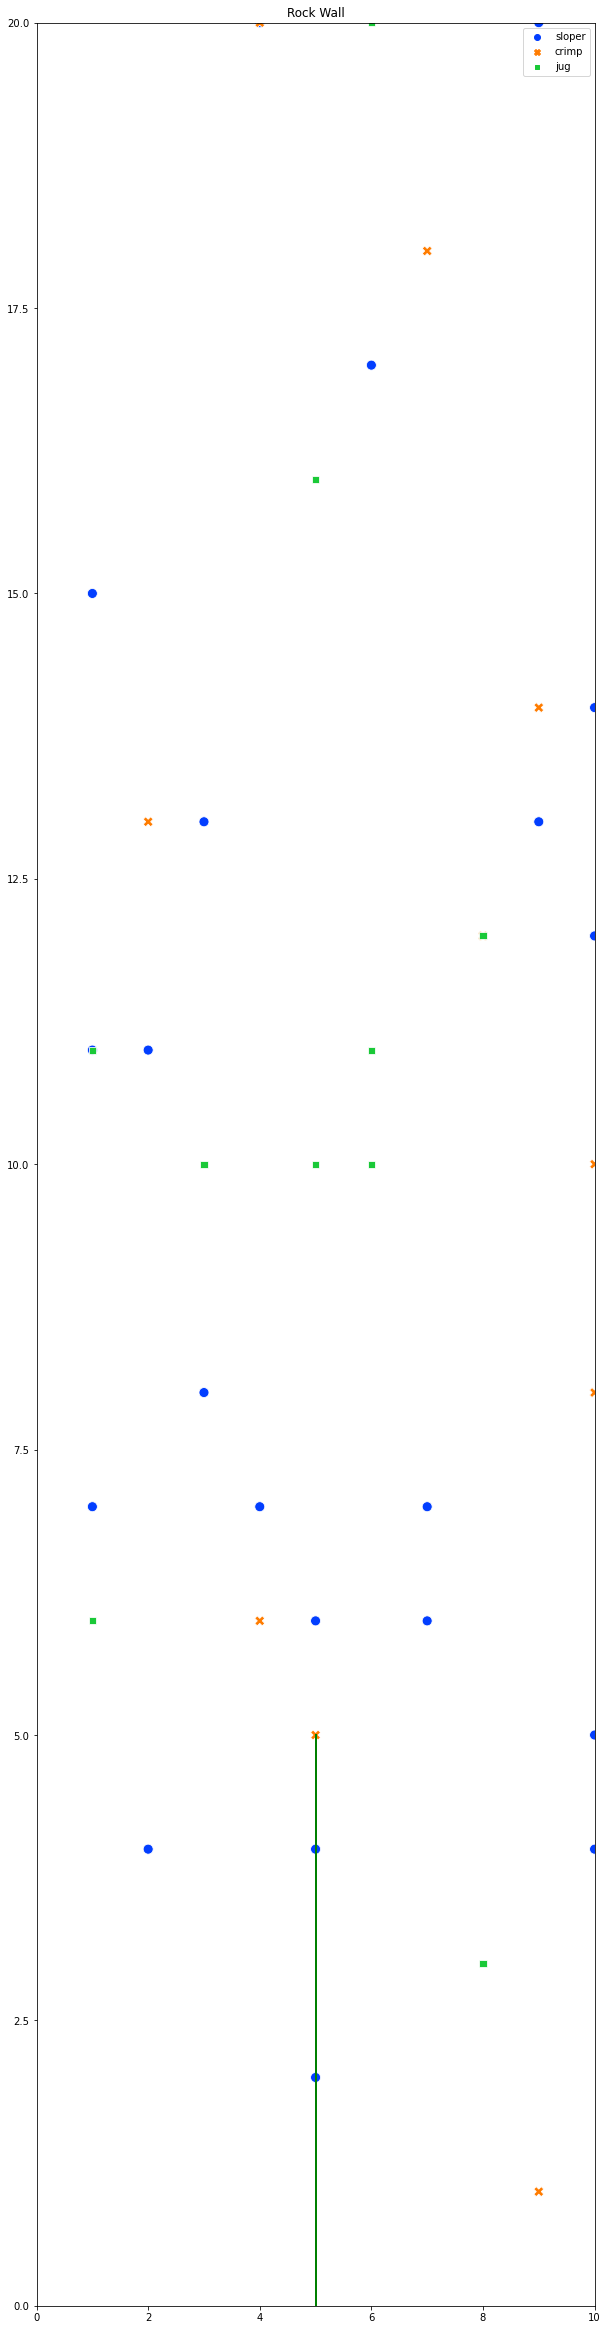

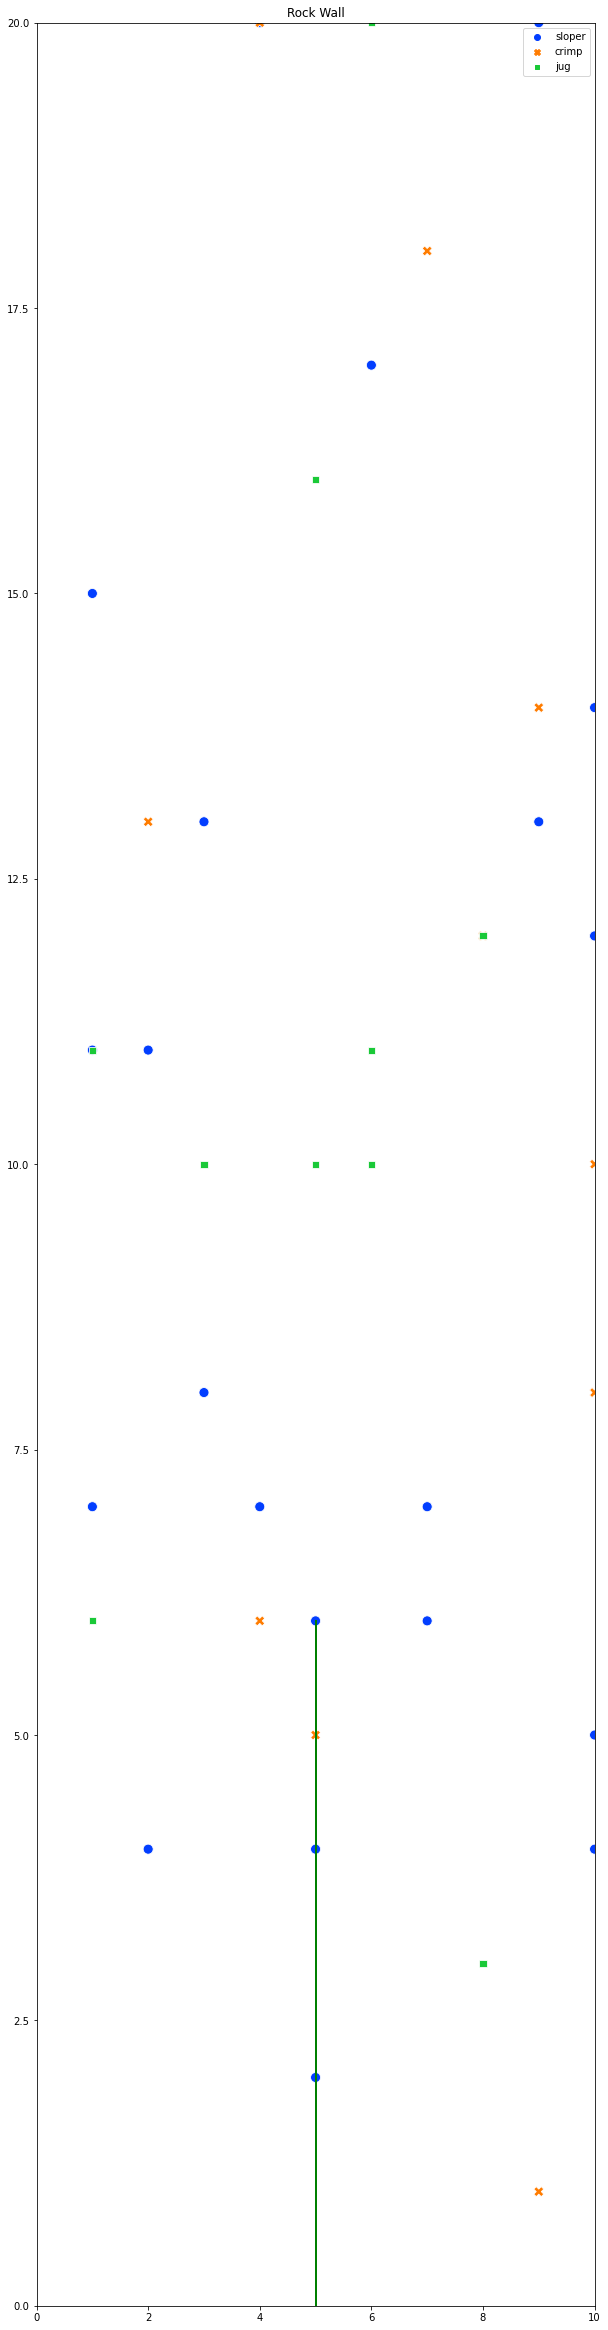

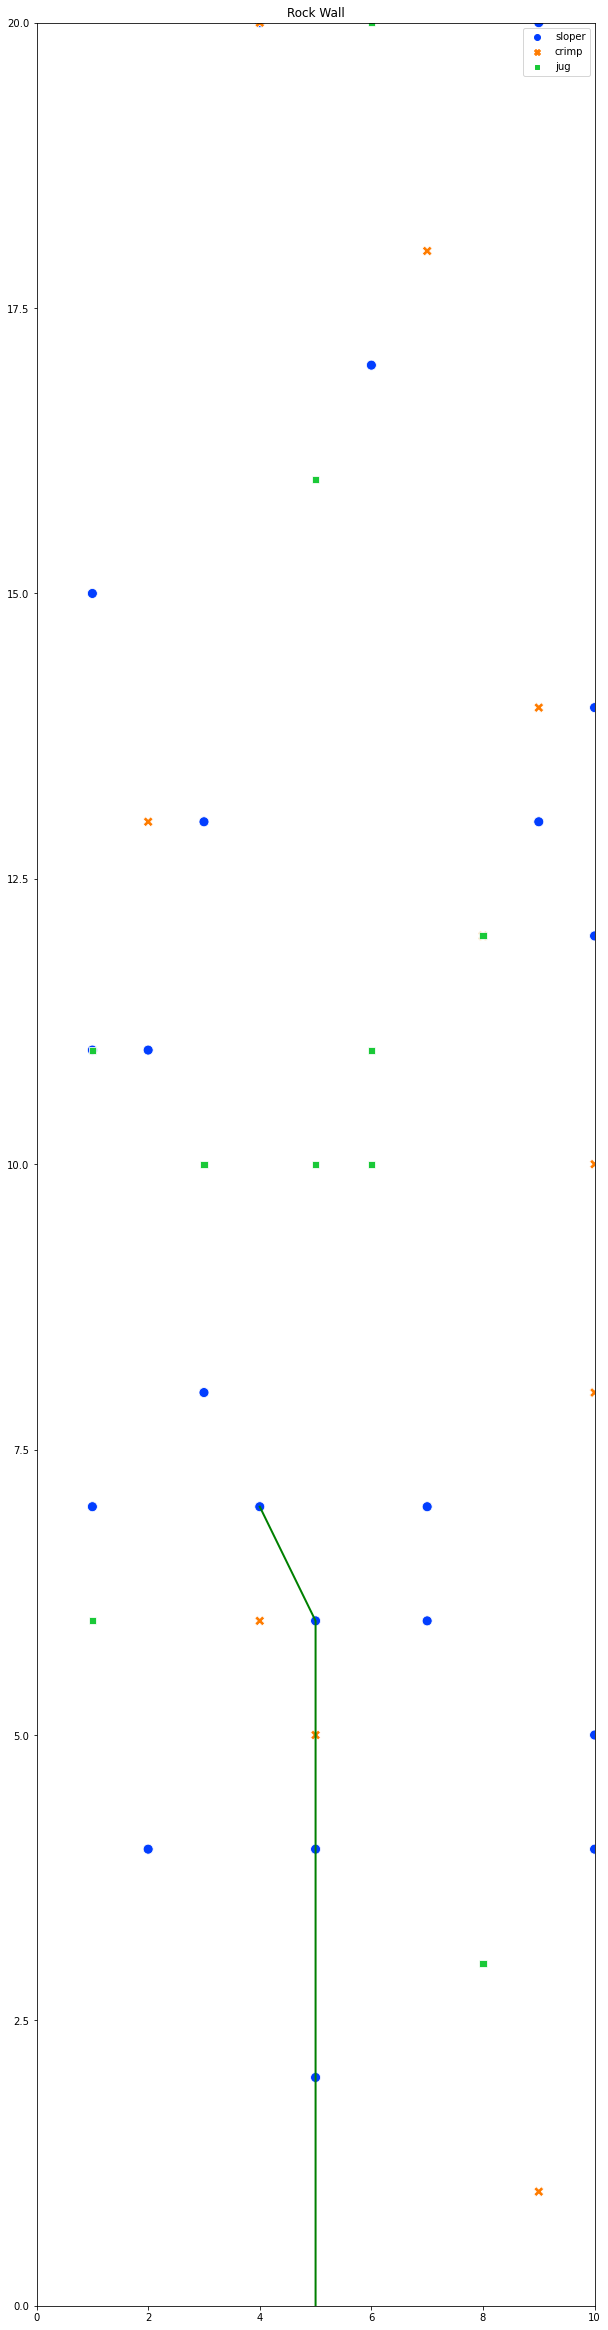

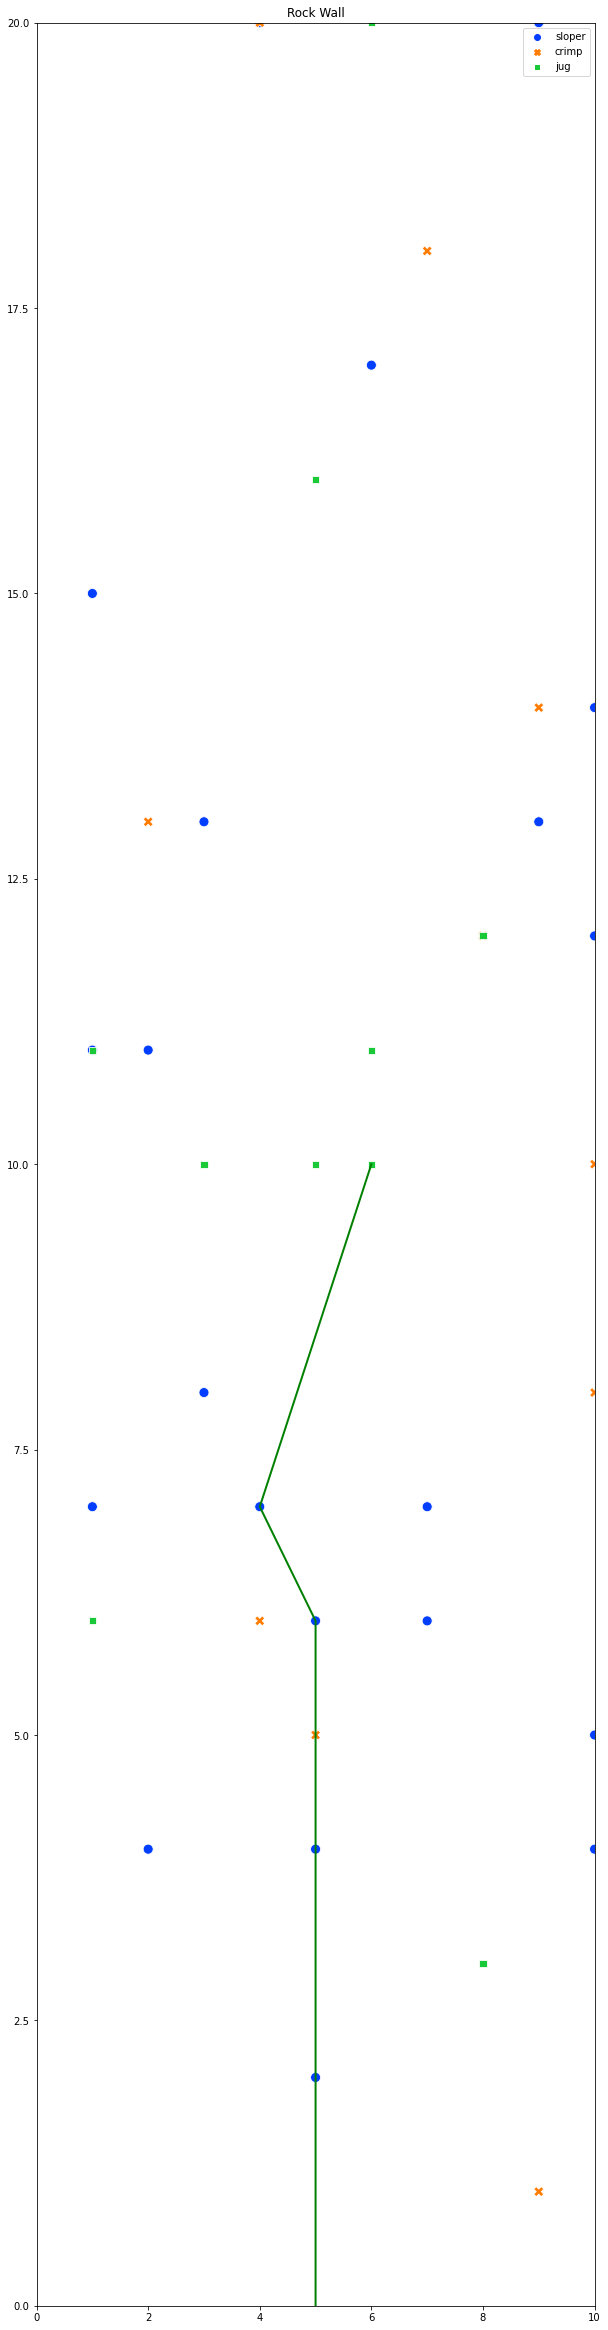

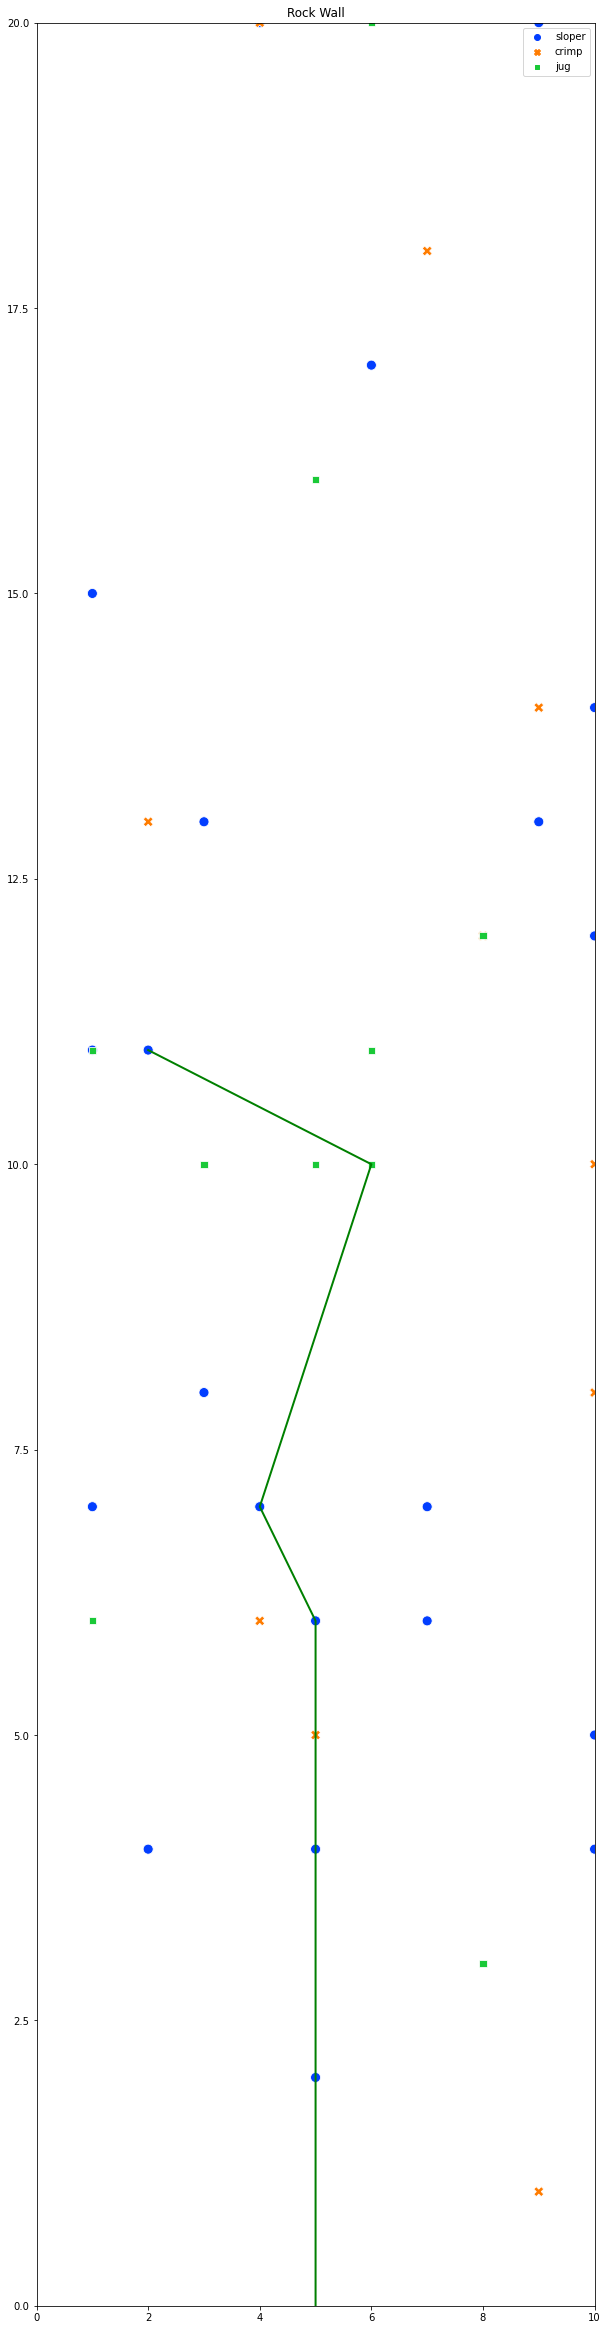

In [27]:
wall1.plot_path(wall1.run_wall(crimp_climber))

Saved all frames
Generating gif...
Gif generated!


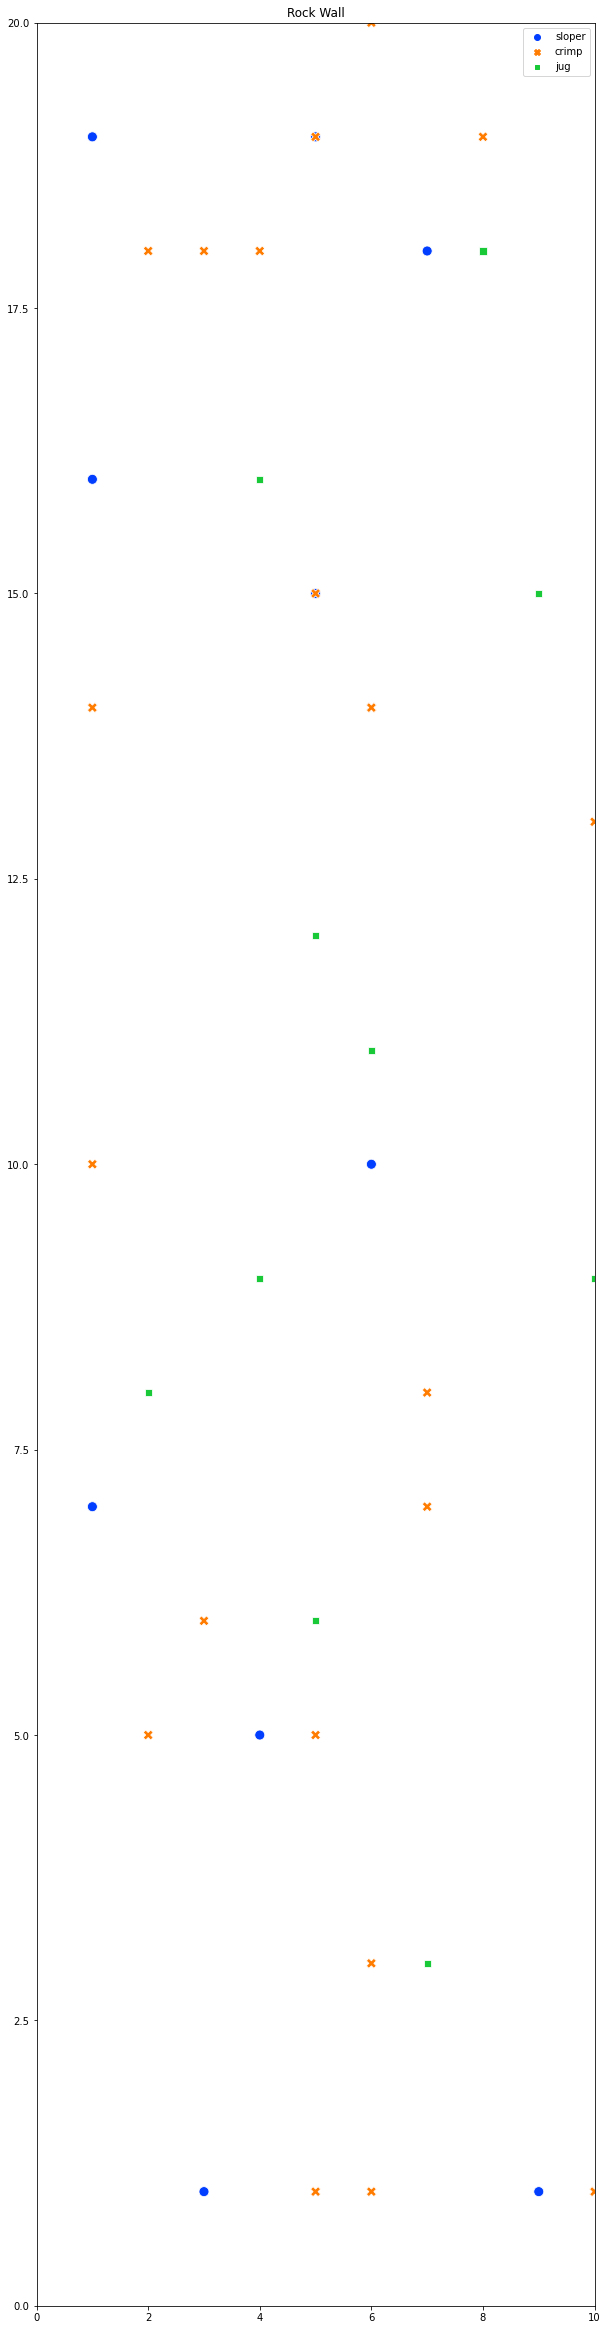

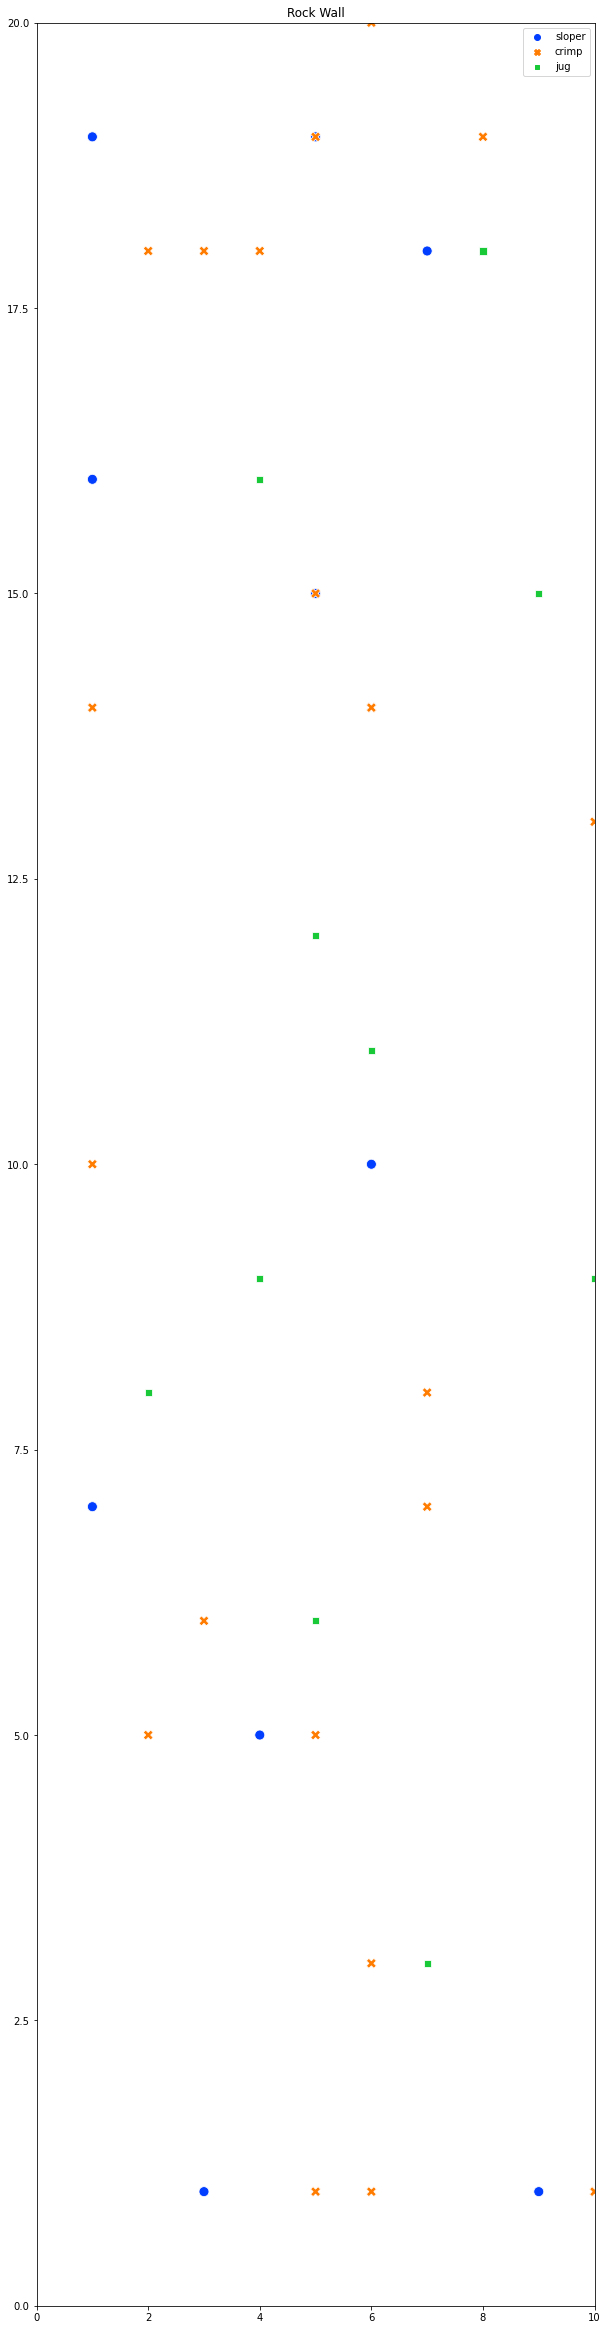

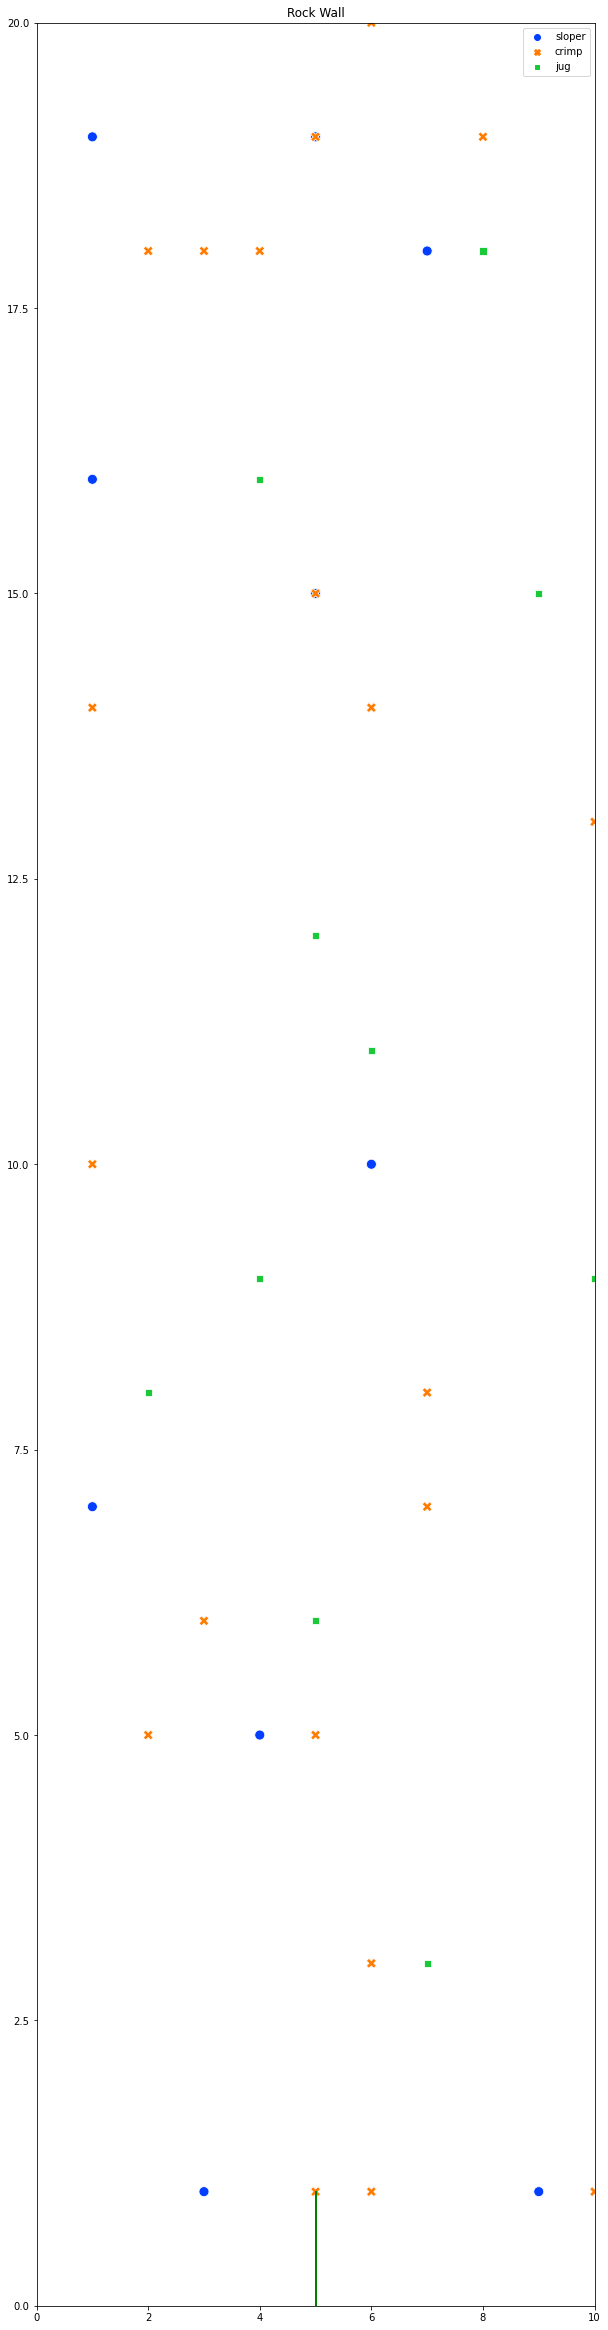

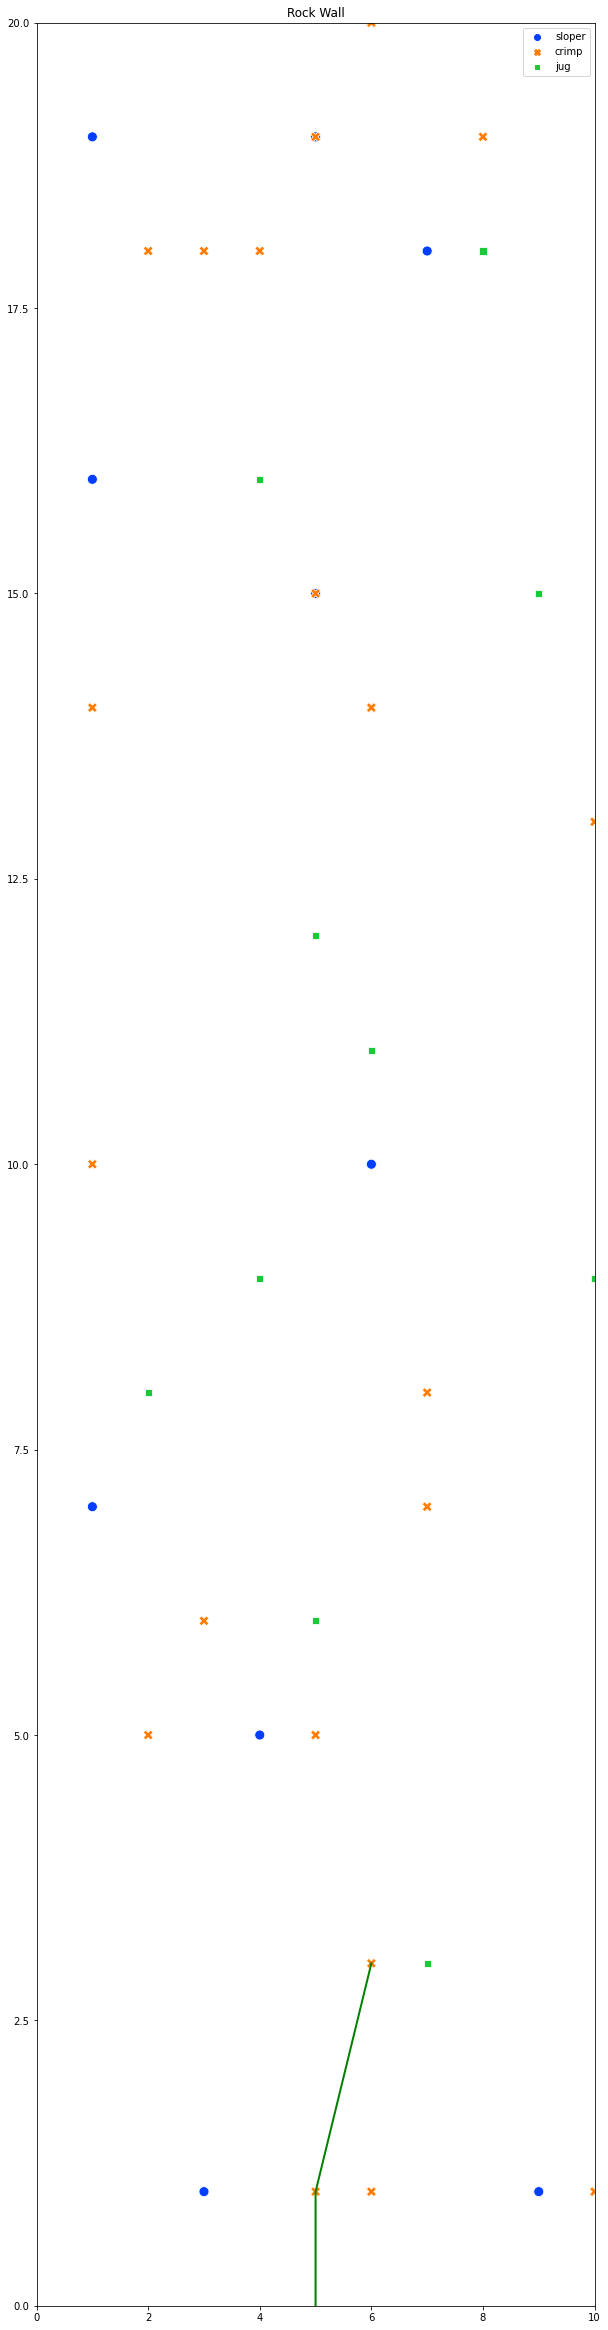

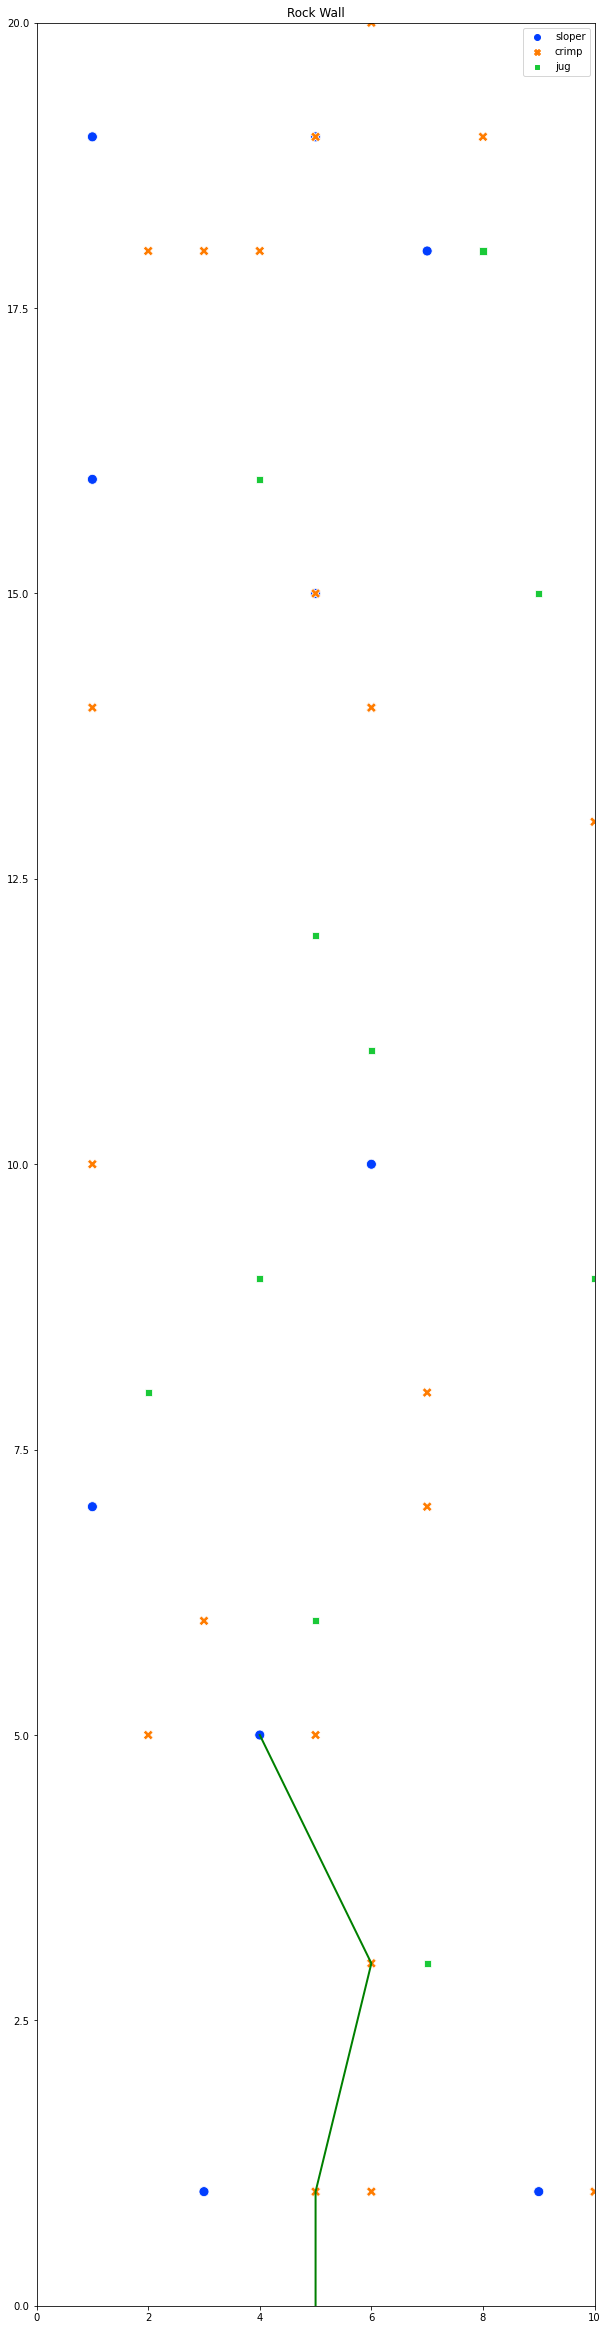

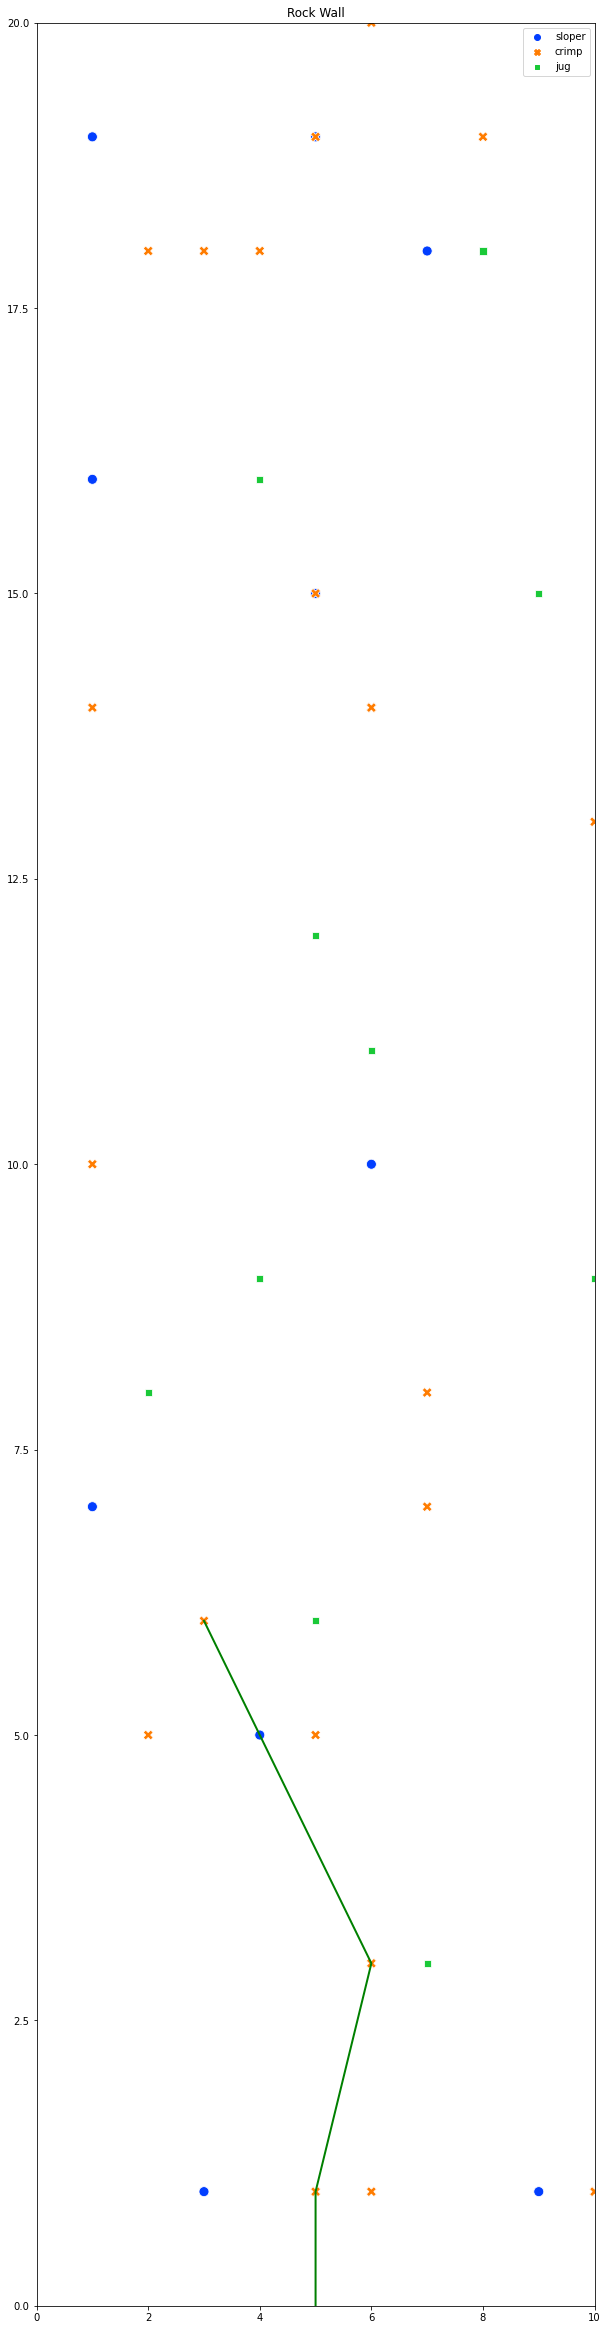

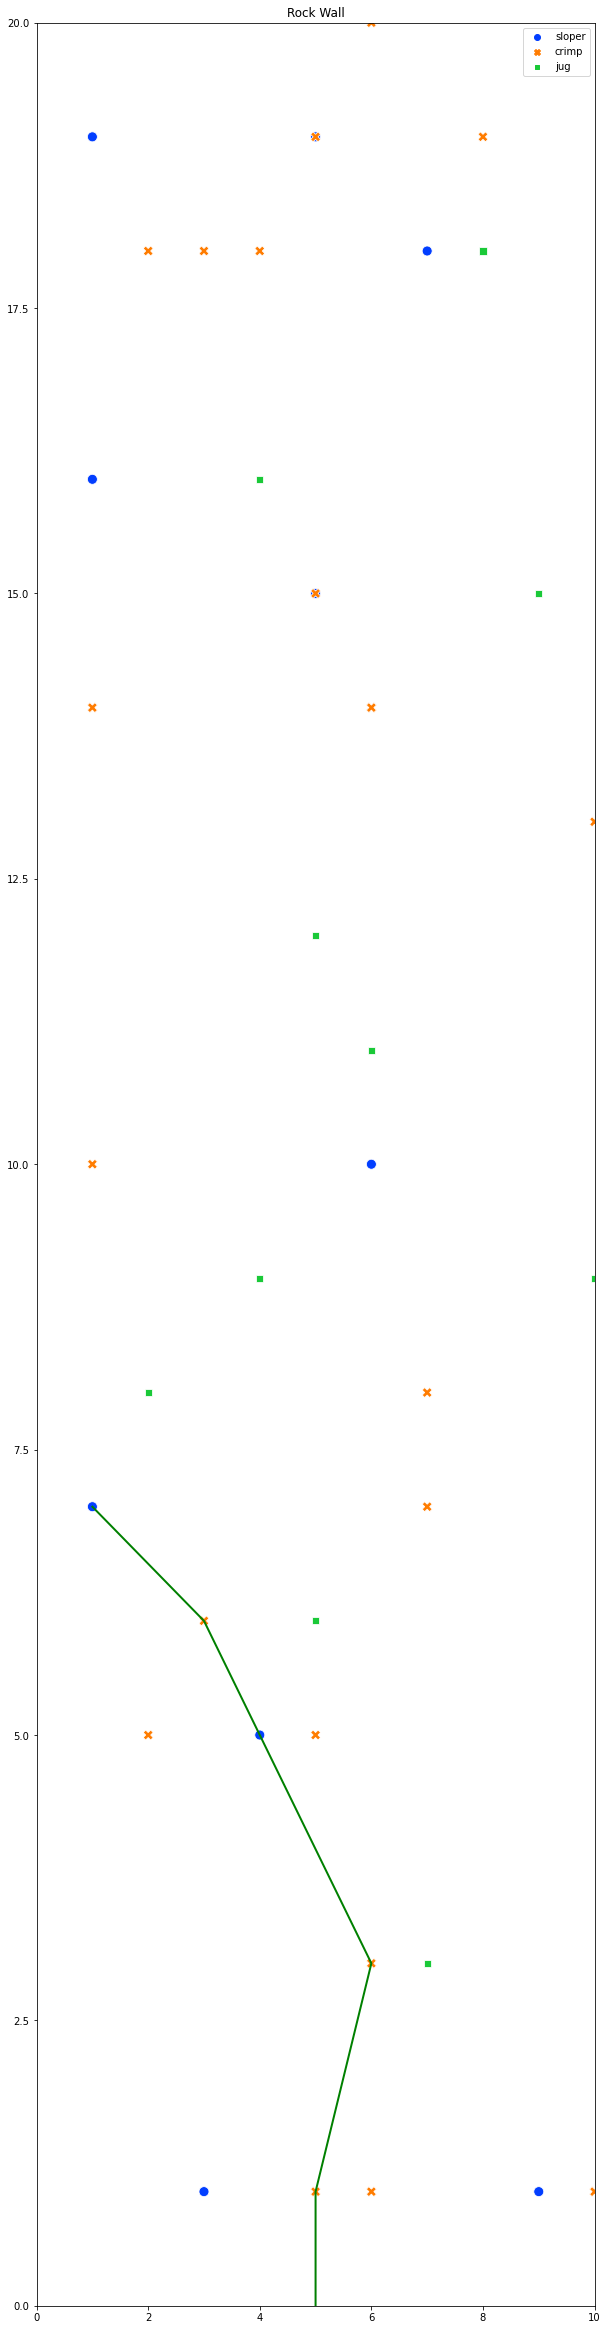

In [29]:
wall2.plot_path(wall2.run_wall(sloper_climber))

Saved all frames
Generating gif...
Gif generated!


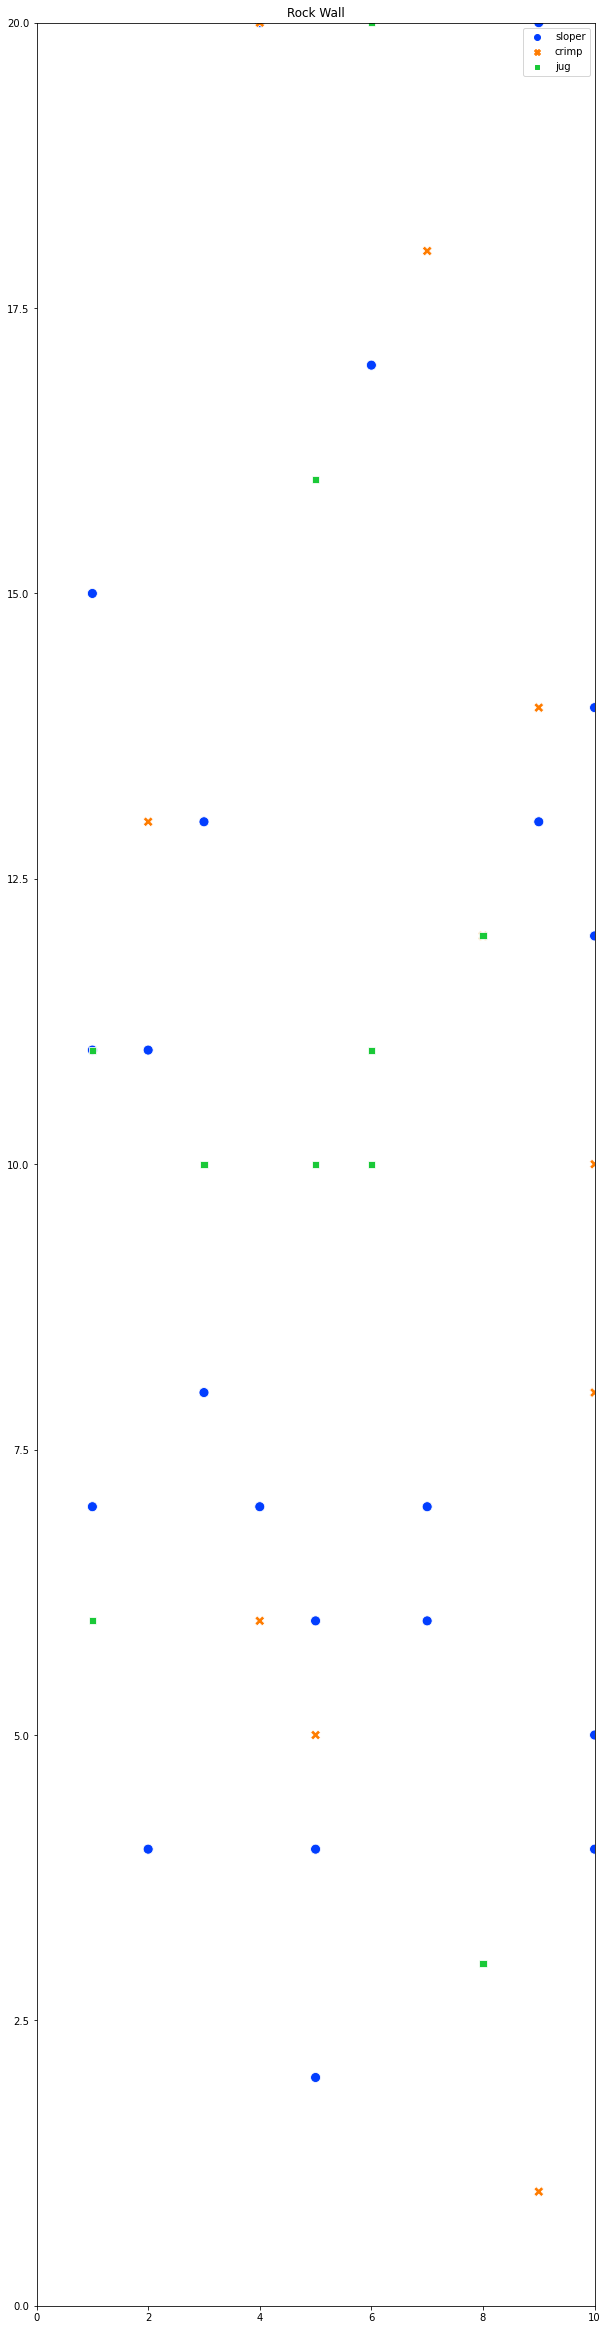

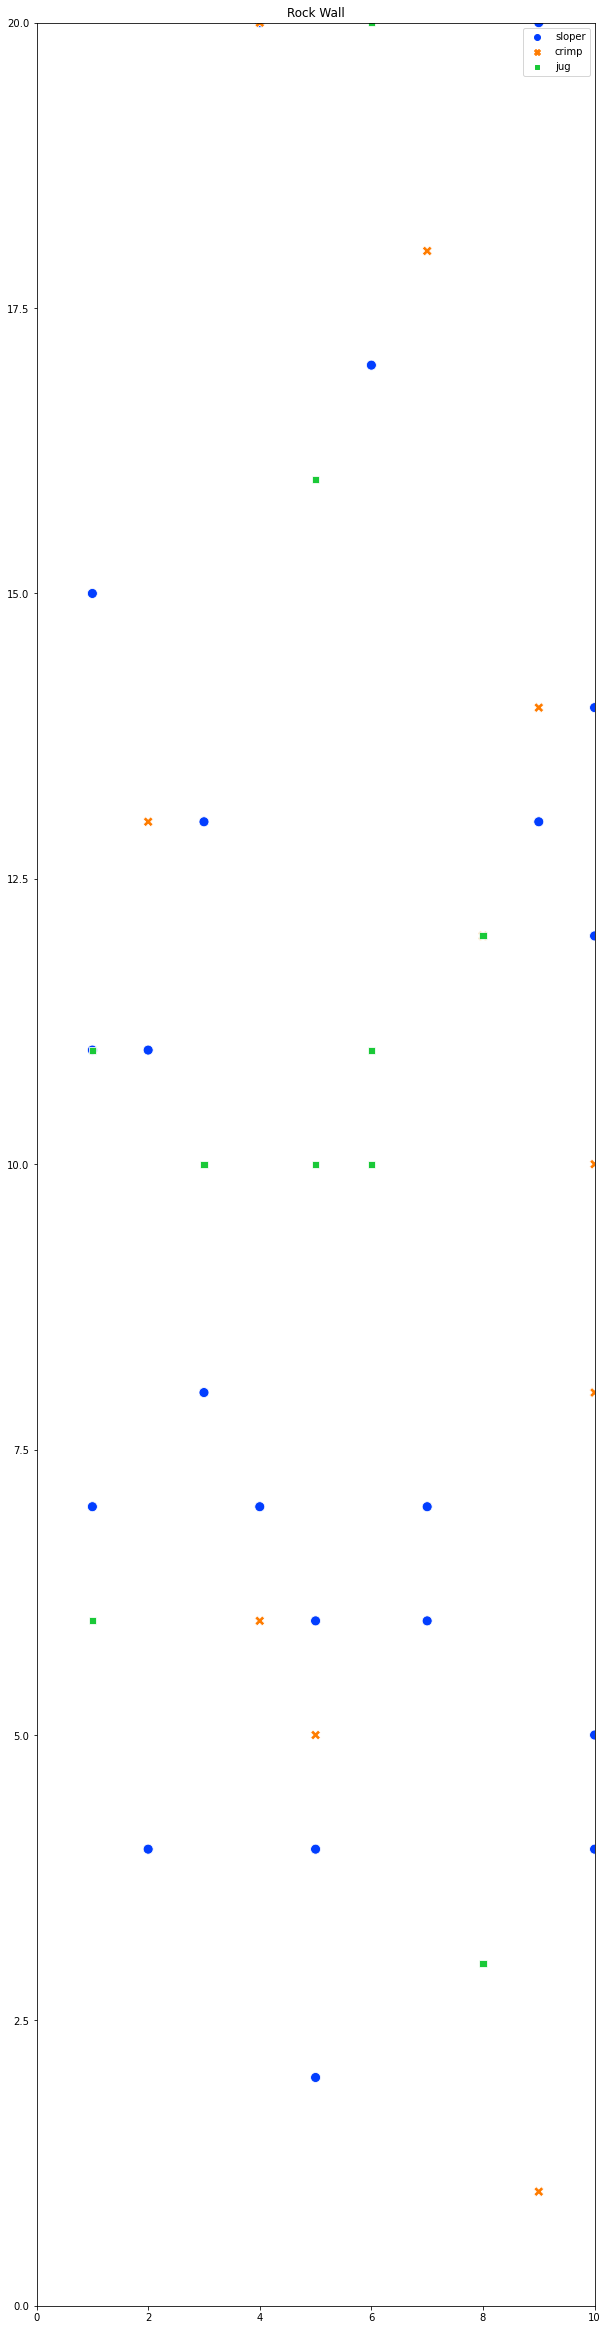

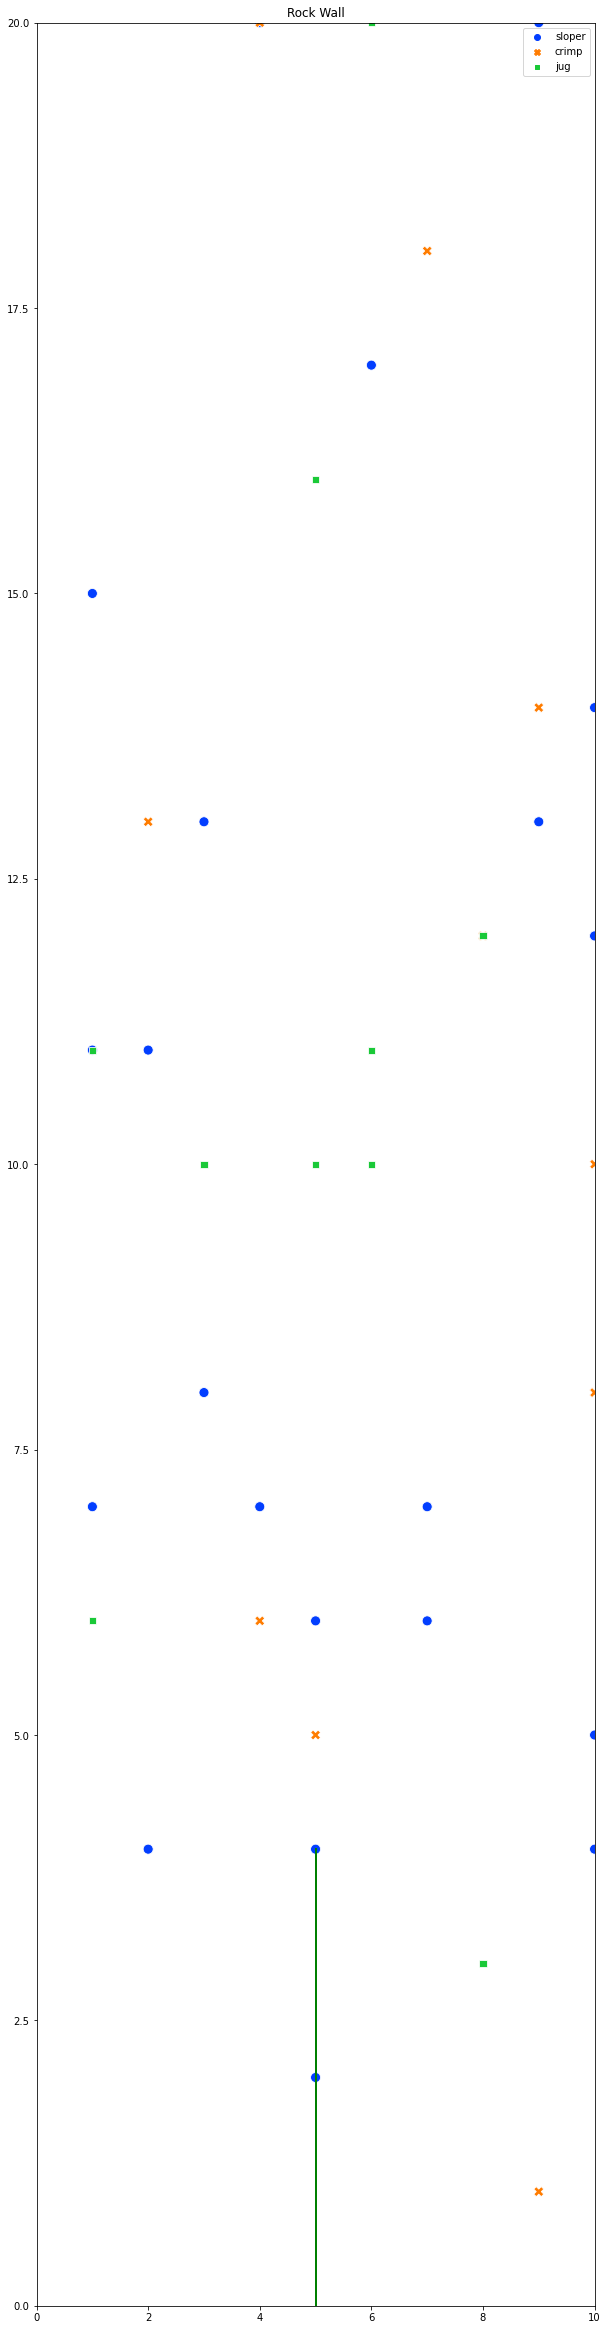

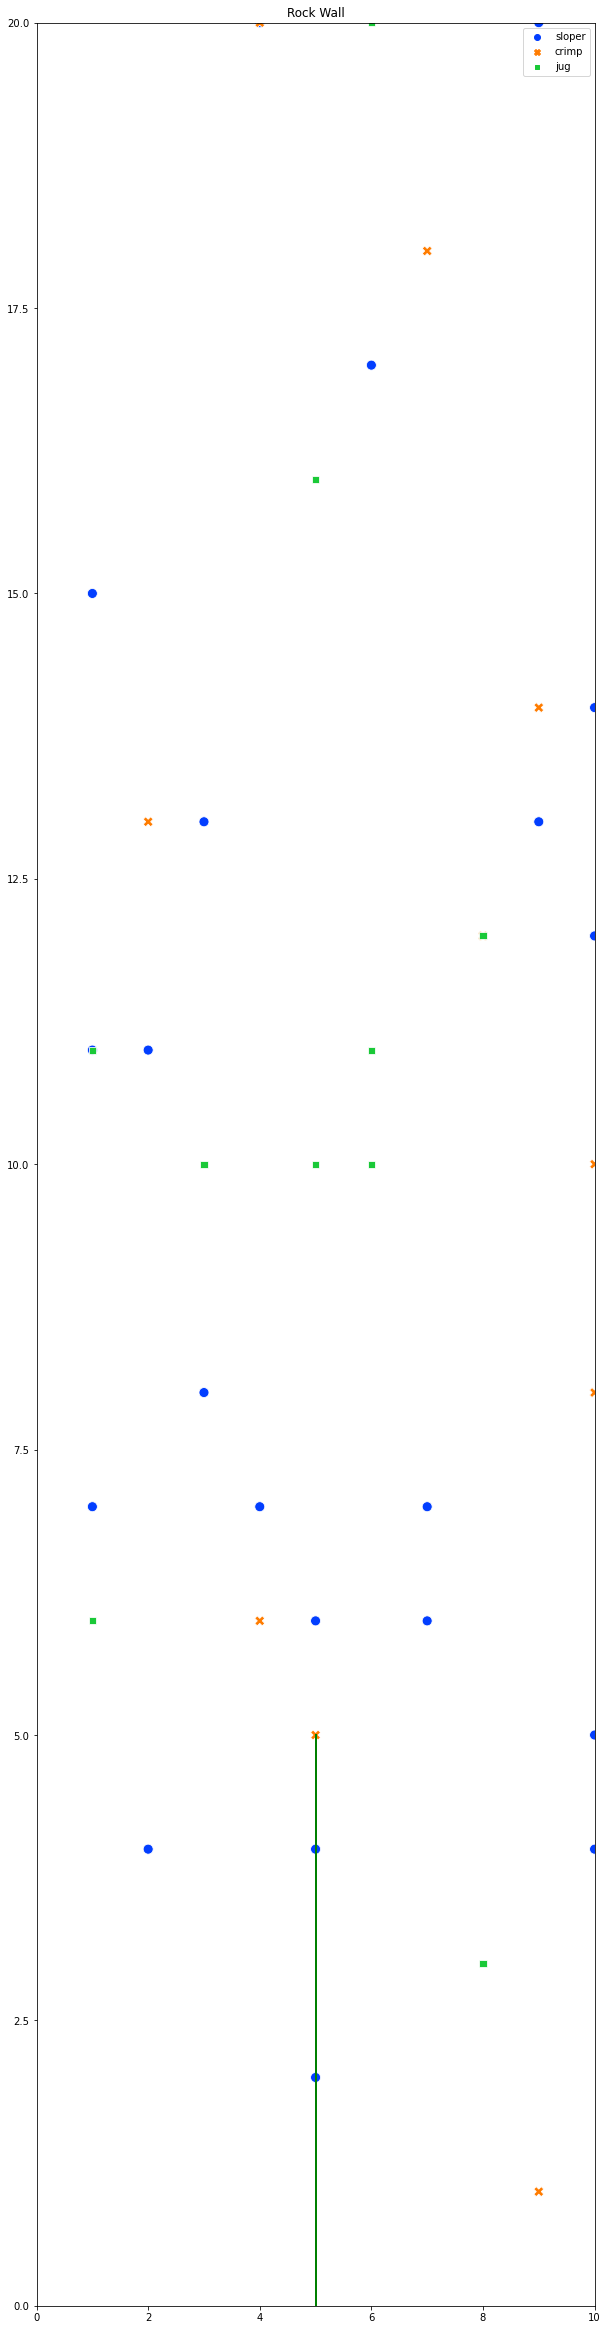

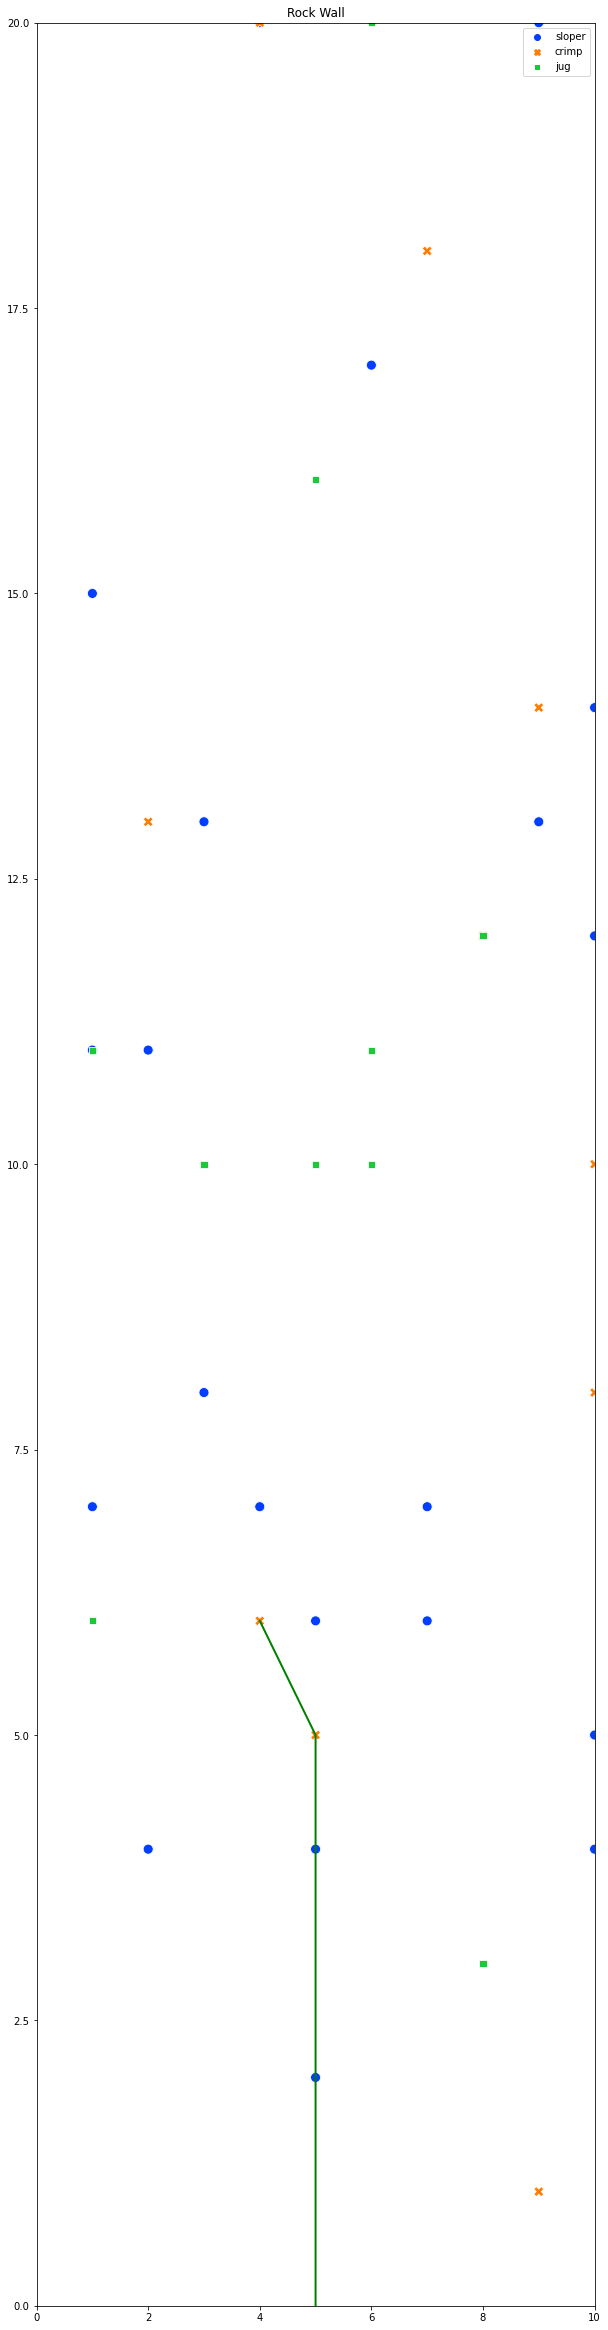

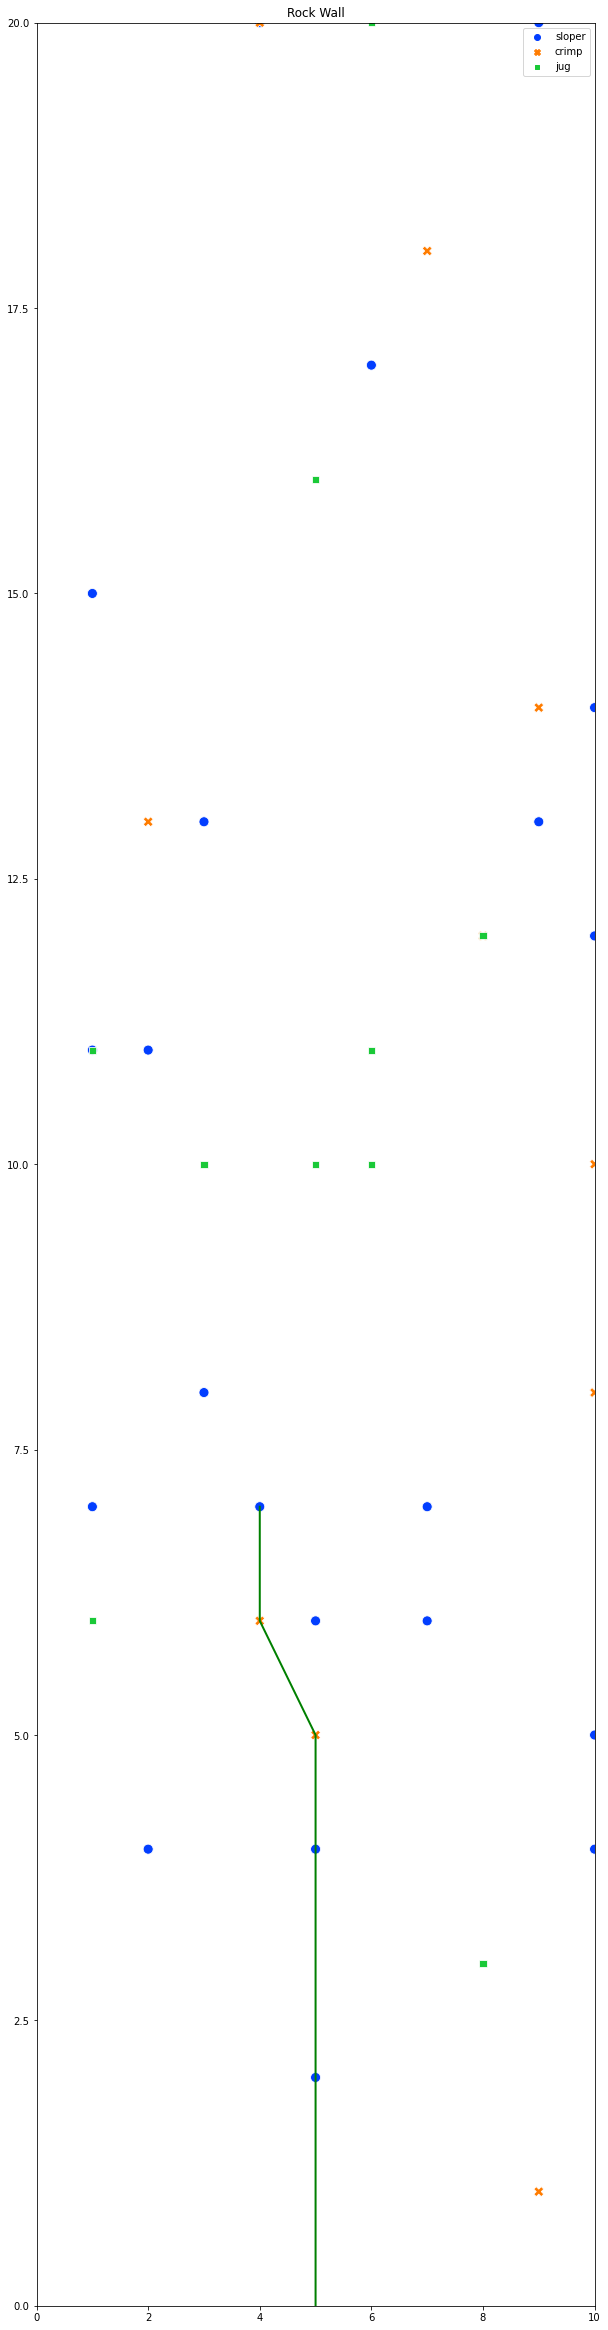

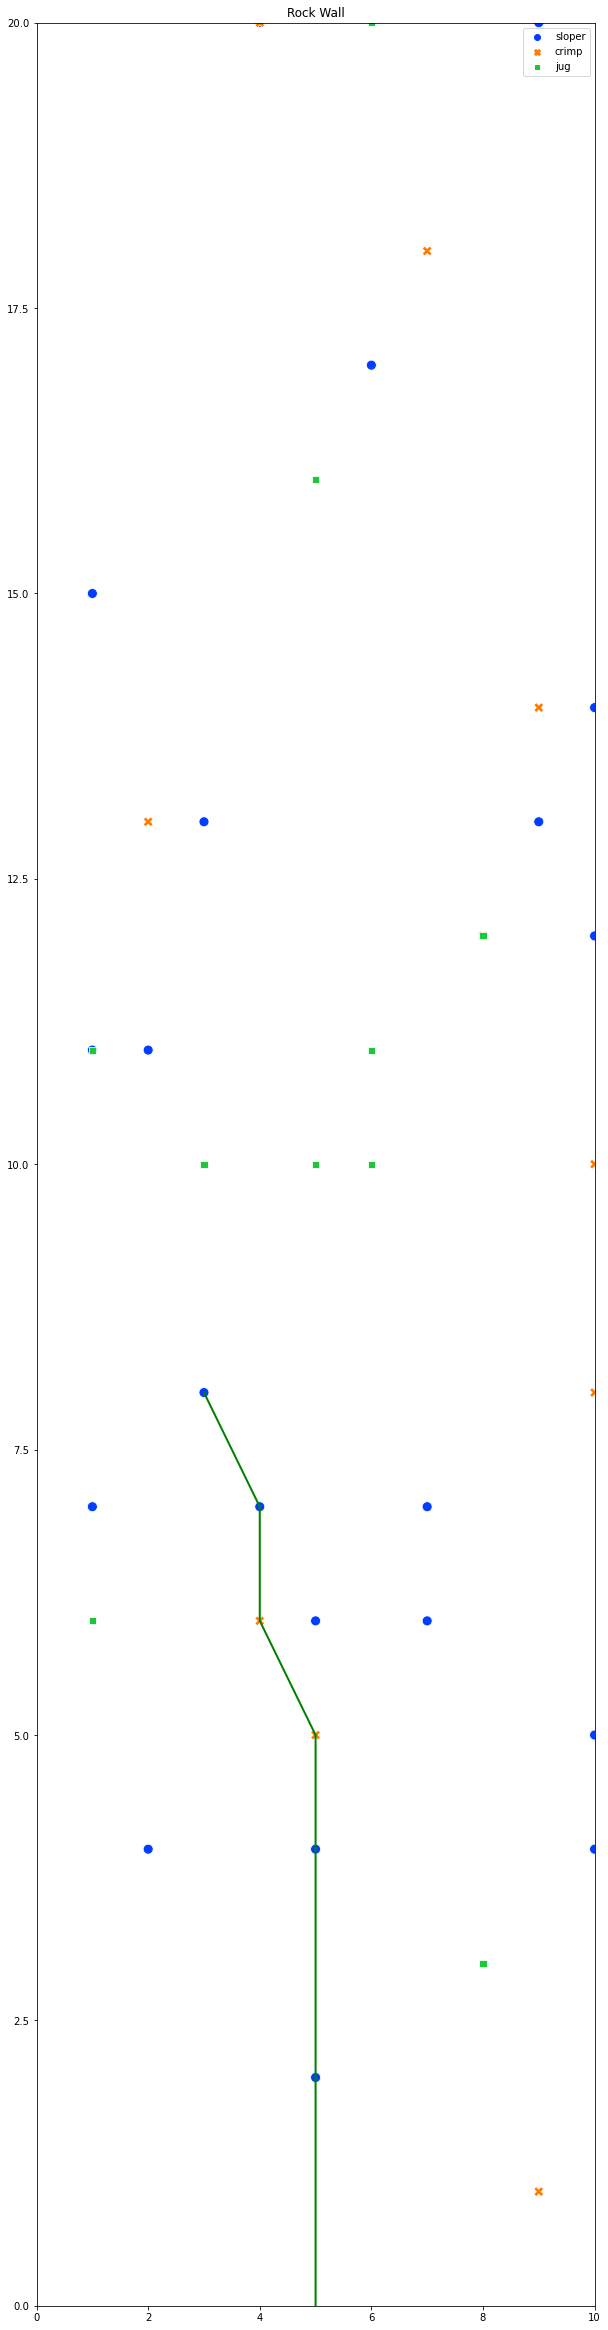

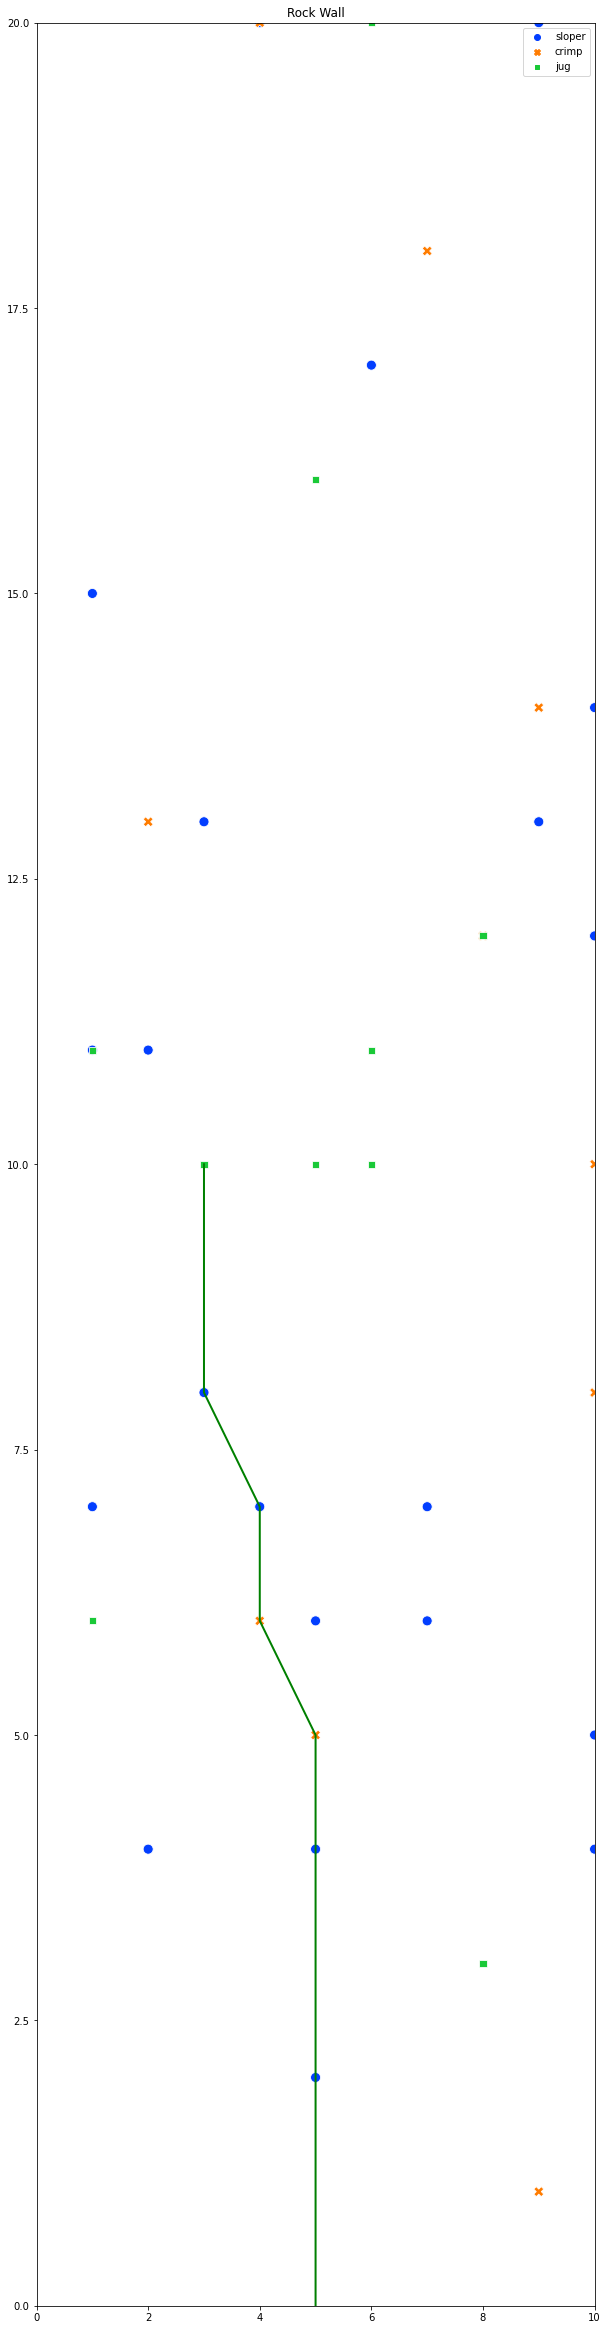

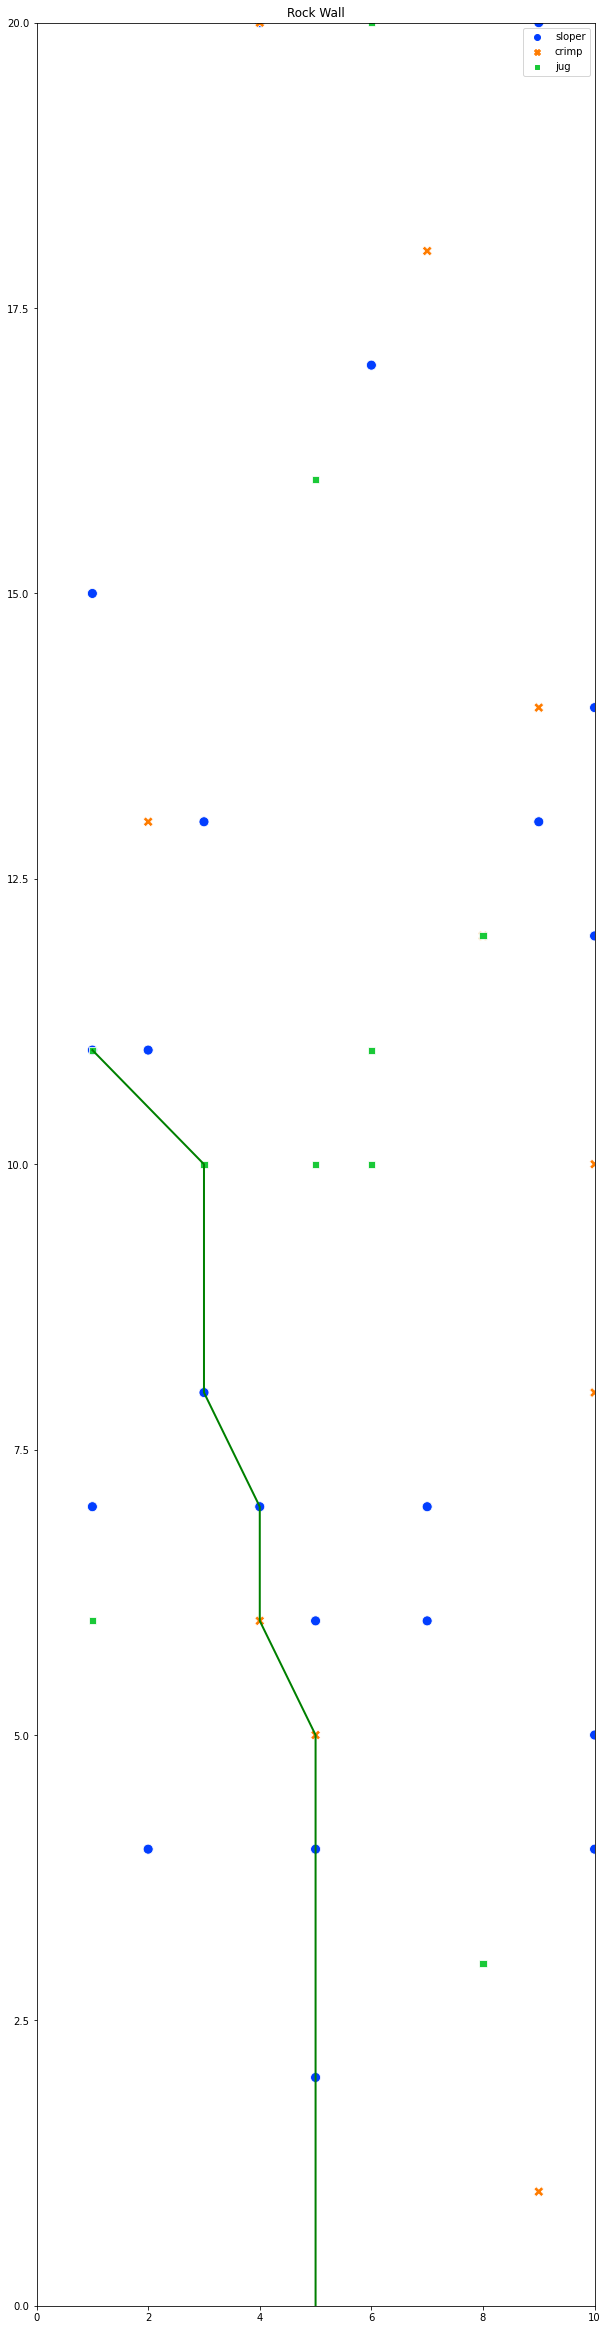

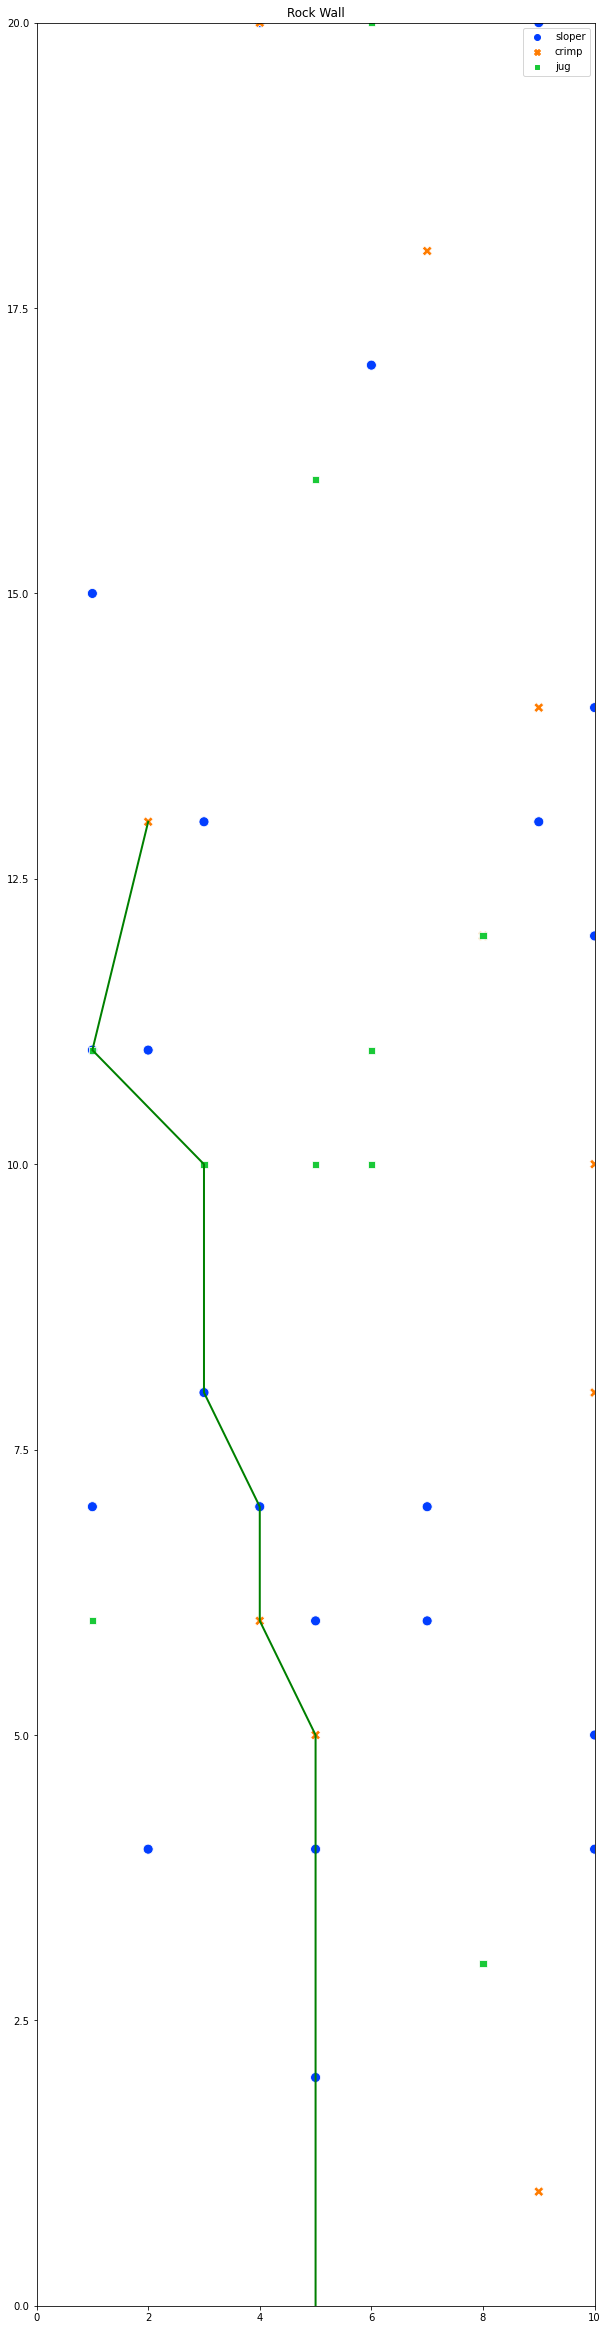

In [30]:
wall1.plot_path(wall1.run_wall(crimp_climber))

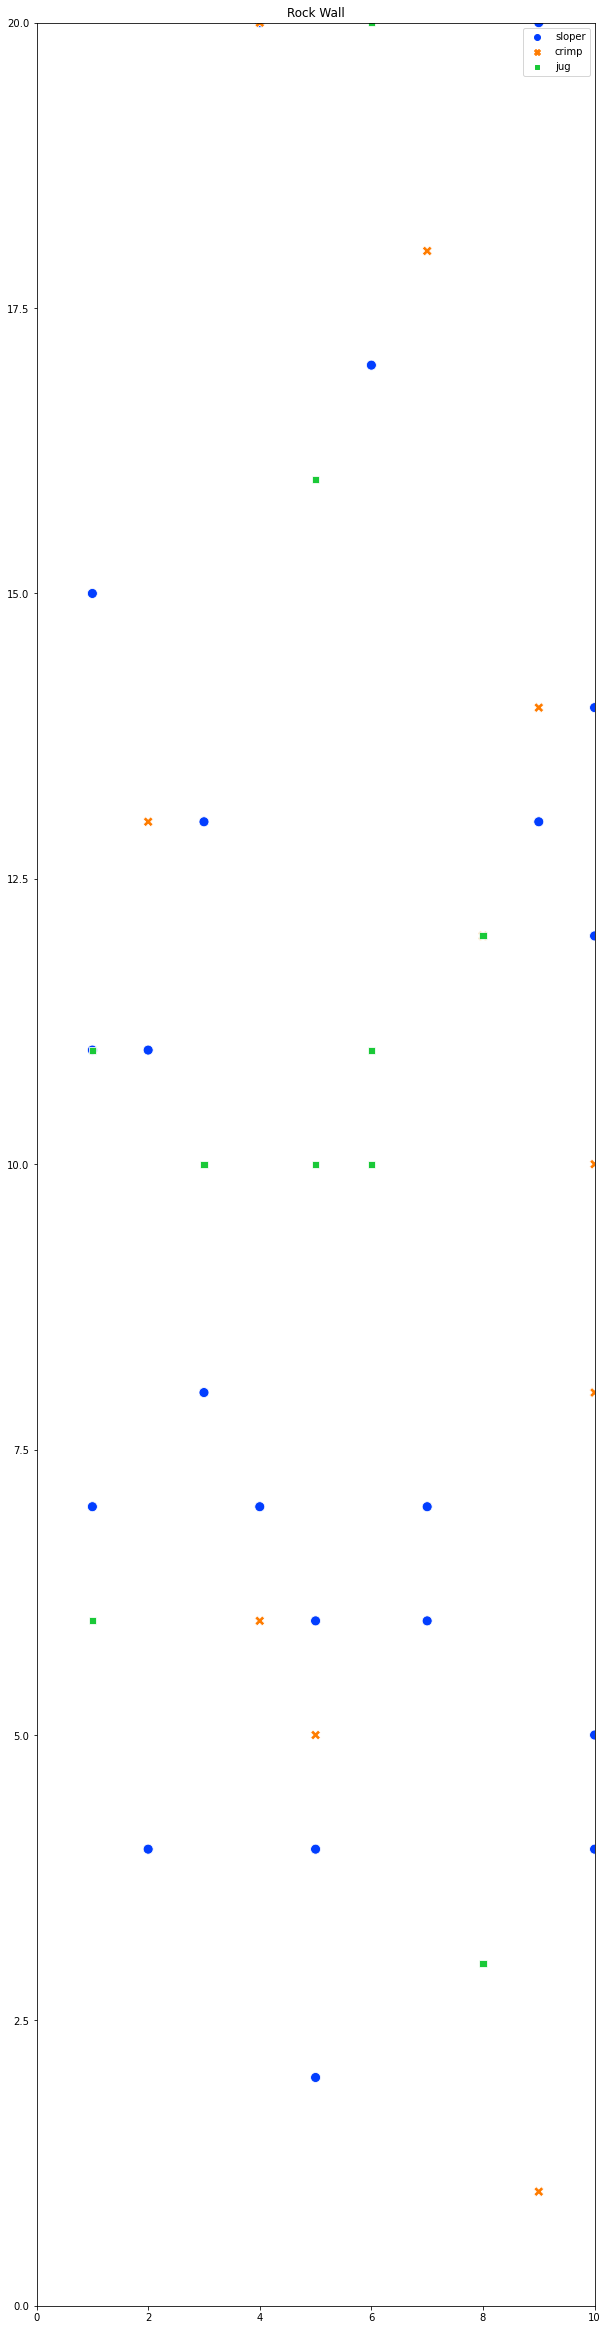

In [31]:
wall1.show()

#### In order to answer our question, we're going to create 400 climbers and 20 walls. Of the 400 climbers . . .

#### 100 will excel at slopers

#### 100 will excel at crimps

#### 100 will excel at jugs

#### 100 will be jacks of all trades

#### We will do a similar thing for the walls. We'll create some walls that have even amounts of each rock, and other walls that have more of other rocks.

We have to keep in mind that some holds are harder than others. In particular, Jugs are the easiest, Crimps are in the middle, and Slopers are the hardest. If we didn't take this into account, then all the different holds would essentially be the same. 

This also means we need to set a base value for each hold. ***We'll set Sloper to 0.4, Crimp to 0.5, and Jug to 0.6.*** From here, we can make climbers with reasonable data. 

In [67]:
# Let's make some climbers

sloper_climbers = create_climbers(100, [4, 6], [.65, .75], [.45, .55], [.55, .65])
crimp_climbers = create_climbers(100, [4, 6], [.35, .45], [.75, .85], [.55, .65])
jug_climbers = create_climbers(100, [4, 6], [.35, .45], [.45, .55], [.85, .95])
# We'll give the All Around Climbers a bit of a boost in every stat
all_around_climbers = create_climbers(100, [4, 6], [.45, .55], [.55, .65], [.65, .75])

In [68]:
# Let's make some walls

all_walls = []

for i in range(5):
    all_walls.append(create_wall(10,7,7,7))
    all_walls.append(create_wall(10,11,5,5))
    all_walls.append(create_wall(10,5,11,5))
    all_walls.append(create_wall(10,5,5,11))

#### Now we're ready to simulate and collect data

In [69]:
sloper_h = []

simulate(sloper_climbers, all_walls)
for climber in sloper_climbers:
    sloper_h.append(climber.average_h())

In [70]:
crimp_h = []

simulate(crimp_climbers, all_walls)
for climber in crimp_climbers:
    crimp_h.append(climber.average_h())

In [71]:
jug_h = []

simulate(jug_climbers, all_walls)
for climber in jug_climbers:
    jug_h.append(climber.average_h())

In [72]:
all_around_h = []

simulate(all_around_climbers, all_walls)
for climber in all_around_climbers:
    all_around_h.append(climber.average_h())

### Data Analysis Code

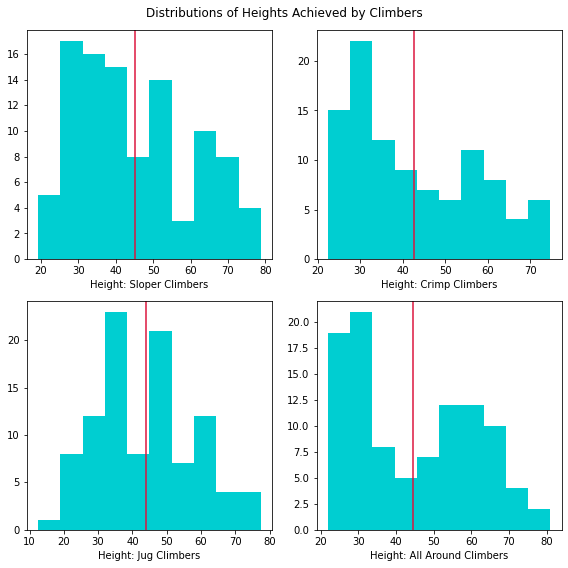

In [85]:
plt.figure(figsize=(8, 8))
plt.suptitle('Distributions of Heights Achieved by Climbers')

plt.subplot(2,2,1) # The first subplot of the 2x2
plt.hist(sloper_h, color='darkturquoise')
plt.axvline(np.mean(sloper_h), color='crimson')
plt.xlabel('Height: Sloper Climbers')

plt.subplot(2,2,2) # The second subplot of the 2x2
plt.hist(crimp_h, color='darkturquoise')
plt.axvline(np.mean(crimp_h), color='crimson')
plt.xlabel('Height: Crimp Climbers')

plt.subplot(2,2,3) # The third subplot of the 2x2
plt.hist(jug_h, color='darkturquoise')
plt.axvline(np.mean(jug_h), color='crimson')
plt.xlabel('Height: Jug Climbers')

plt.subplot(2,2,4) # The fourth subplot of the 2x2
plt.hist(all_around_h, color='darkturquoise')
plt.axvline(np.mean(all_around_h), color='crimson')
plt.xlabel('Height: All Around Climbers')
plt.tight_layout()

In [83]:
#Regression code
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#Linear regression plan:

#Need to import pandas to store the data and linear_model from sklearn

#Store the data we want in a dataframe

#Run regression using LinearRegression() function

#Data we'll need since the other data has funky distribution that makes meaningful interpretation of results challenging:

new_climbers = create_climbers(100, [4, 6], [.2, .8], [.2, .8], [.2, .8])
new_h = []

simulate(new_climbers, all_walls)
for climber in new_climbers:
    new_h.append(climber.average_h())

#Dataframe which stores characteristics of each climber,and how far they got with each wall.

#Creating the Dataframe
regheight = []
regsloper = []
regcrimp = []
regjug = []
regreach = []

for i in range(0, 100): #adjust for # of climbers
    regheight.append(new_h[i])
    
    regsloper.append(new_climbers[i].sloper)
    
    regcrimp.append(new_climbers[i].crimp)
    
    regjug.append(new_climbers[i].jug)
    
    regreach.append(new_climbers[i].reach)

#Dictionary containing the data,anywhere that has #data, input the the variables that store the data from our simluations

data = {'height': regheight,
        'sloper': regsloper,
        'crimp': regcrimp,
       'jug': regjug,
       'reach': regreach}

climberdf = pd.DataFrame(data) #storing the data into a df
        
#Run the regression here:
        
x = climberdf[['sloper', 'crimp', 'jug', 'reach']]
y = climberdf['height']
        
model = sm.OLS(y, x)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 height   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              96.71
Date:                Mon, 24 Apr 2023   Prob (F-statistic):                    8.35e-33
Time:                        18:48:10   Log-Likelihood:                         -429.80
No. Observations:                 100   AIC:                                      867.6
Df Residuals:                      96   BIC:                                      878.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sloper        19.4984     10.822      1.802      0.075      -1.984      40.981
crimp          7.9965      9.997      0.800      0.426     -11.846      27.839
jug            5.9944     10.748      0.558      0.578     -15.341      27.330
reach          3.7475      1.494      2.509      0.014       0.783       6.712
==============================================================================
Omnibus:                       11.421   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.879
Skew:                           0.877   Prob(JB):                      0.00160
Kurtosis:                       2.869   Cond. No.                         34.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""